In [1]:
# %pip install torch torchvision torchaudio
# %pip install pandas numpy pillow tqdm matplotlib seaborn scikit-learn jupyter notebook ipykernel
# %pip install xgboost lightgbm --config-settings=cmake.define.USE_GPU=ON

## Cell 0: Environment Check

In [2]:
import os
os.getcwd()

'/home/nnik345/Projects/College/Computer Vision/Galaxy Analysis'

## Cell 1: Import Libraries

In [3]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Tuple, Dict, List
import warnings
import time
import json
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

# Visualization and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

# Progress tracking
from tqdm import tqdm

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.5 GB


## Cell 2: Global Configuration

In [4]:
# ============================================================
# GLOBAL CONFIGURATION (SHARED ACROSS ALL MODELS)
# ============================================================

# Data paths
DATA_DIR = Path("Dataset")
IMAGES_DIR = DATA_DIR / "images"
MAPPING_CSV = DATA_DIR / "gz2_filename_mapping.csv"
LABELS_CSV = DATA_DIR / "gz2_hart16.csv"

# Data parameters
DATA_FRACTION = 0.2
CLEAN_SAMPLE_ONLY = True
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# Image parameters
IMAGE_SIZE = 224
NUM_WORKERS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters (base)
BASE_NUM_EPOCHS = 250
BASE_LEARNING_RATE = 0.0005
BASE_WEIGHT_DECAY = 1e-4
BASE_PATIENCE = 10

# Output structure
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

print("="*60)
print("GLOBAL CONFIGURATION")
print("="*60)
print(f"Data fraction: {DATA_FRACTION*100:.1f}%")
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Device: {DEVICE}")
print(f"Base learning rate: {BASE_LEARNING_RATE}")
print(f"Base epochs: {BASE_NUM_EPOCHS}")
print("="*60)

GLOBAL CONFIGURATION
Data fraction: 20.0%
Image size: 224x224
Device: cuda
Base learning rate: 0.0005
Base epochs: 250


## Cell 3: Task Definition

In [5]:
# ============================================================
# TASK METADATA (10 TASKS - TASK_08 REMOVED AND RENUMBERED)
# ============================================================

TASK_METADATA = {
    'task_01_smooth_features': {
        'question': 'Smooth vs features/disk vs star/artifact?',
        'answers': {
            'smooth': 't01_smooth_or_features_a01_smooth_debiased',
            'features_or_disk': 't01_smooth_or_features_a02_features_or_disk_debiased',
            'star_or_artifact': 't01_smooth_or_features_a03_star_or_artifact_debiased'
        },
        'gate': None
    },
    'task_02_edgeon': {
        'question': 'Edge-on?',
        'answers': {
            'yes': 't02_edgeon_a04_yes_debiased',
            'no': 't02_edgeon_a05_no_debiased'
        },
        'gate': 't01_smooth_or_features_a02_features_or_disk_debiased'
    },
    'task_03_bar': {
        'question': 'Central bar?',
        'answers': {
            'bar': 't03_bar_a06_bar_debiased',
            'no_bar': 't03_bar_a07_no_bar_debiased'
        },
        'gate': 't01_smooth_or_features_a02_features_or_disk_debiased'
    },
    'task_04_spiral': {
        'question': 'Spiral structure?',
        'answers': {
            'spiral': 't04_spiral_a08_spiral_debiased',
            'no_spiral': 't04_spiral_a09_no_spiral_debiased'
        },
        'gate': 't01_smooth_or_features_a02_features_or_disk_debiased'
    },
    'task_05_bulge': {
        'question': 'Bulge prominence?',
        'answers': {
            'no_bulge': 't05_bulge_prominence_a10_no_bulge_debiased',
            'just_noticeable': 't05_bulge_prominence_a11_just_noticeable_debiased',
            'obvious': 't05_bulge_prominence_a12_obvious_debiased',
            'dominant': 't05_bulge_prominence_a13_dominant_debiased'
        },
        'gate': 't01_smooth_or_features_a02_features_or_disk_debiased'
    },
    'task_06_odd': {
        'question': 'Odd/unusual features?',
        'answers': {
            'yes': 't06_odd_a14_yes_debiased',
            'no': 't06_odd_a15_no_debiased'
        },
        'gate': 't01_smooth_or_features_a02_features_or_disk_debiased'
    },
    'task_07_roundness': {
        'question': 'Shape (smooth galaxies)?',
        'answers': {
            'completely_round': 't07_rounded_a16_completely_round_debiased',
            'in_between': 't07_rounded_a17_in_between_debiased',
            'cigar_shaped': 't07_rounded_a18_cigar_shaped_debiased'
        },
        'gate': 't01_smooth_or_features_a01_smooth_debiased'
    },
    'task_08_bulge_shape': {
        'question': 'Bulge shape (edge-on)?',
        'answers': {
            'rounded': 't09_bulge_shape_a25_rounded_debiased',
            'boxy': 't09_bulge_shape_a26_boxy_debiased',
            'no_bulge': 't09_bulge_shape_a27_no_bulge_debiased'
        },
        'gate': 't02_edgeon_a04_yes_debiased'
    },
    'task_09_arm_winding': {
        'question': 'Spiral arm winding?',
        'answers': {
            'tight': 't10_arms_winding_a28_tight_debiased',
            'medium': 't10_arms_winding_a29_medium_debiased',
            'loose': 't10_arms_winding_a30_loose_debiased'
        },
        'gate': 't04_spiral_a08_spiral_debiased'
    },
    'task_10_arm_number': {
        'question': 'Number of spiral arms?',
        'answers': {
            '1': 't11_arms_number_a31_1_debiased',
            '2': 't11_arms_number_a32_2_debiased',
            '3': 't11_arms_number_a33_3_debiased',
            '4': 't11_arms_number_a34_4_debiased',
            'more_than_4': 't11_arms_number_a36_more_than_4_debiased',
            'cant_tell': 't11_arms_number_a37_cant_tell_debiased'
        },
        'gate': 't04_spiral_a08_spiral_debiased'
    }
}

# Extract label columns
LABEL_COLUMNS = []
for task_name, task_info in TASK_METADATA.items():
    LABEL_COLUMNS.extend(task_info['answers'].values())

print(f"Tasks to predict: {len(TASK_METADATA)}")
print(f"Total outputs: {len(LABEL_COLUMNS)}")
print("\nTask structure:")
for task_name, task_info in TASK_METADATA.items():
    num_answers = len(task_info['answers'])
    gate = task_info['gate'] if task_info['gate'] else "NONE (top-level)"
    print(f"  {task_name}: {num_answers} answers")
    print(f"      Gate: {gate}")
    for answer in task_info['answers'].keys():
        print(f"      - {answer}")

Tasks to predict: 10
Total outputs: 30

Task structure:
  task_01_smooth_features: 3 answers
      Gate: NONE (top-level)
      - smooth
      - features_or_disk
      - star_or_artifact
  task_02_edgeon: 2 answers
      Gate: t01_smooth_or_features_a02_features_or_disk_debiased
      - yes
      - no
  task_03_bar: 2 answers
      Gate: t01_smooth_or_features_a02_features_or_disk_debiased
      - bar
      - no_bar
  task_04_spiral: 2 answers
      Gate: t01_smooth_or_features_a02_features_or_disk_debiased
      - spiral
      - no_spiral
  task_05_bulge: 4 answers
      Gate: t01_smooth_or_features_a02_features_or_disk_debiased
      - no_bulge
      - just_noticeable
      - obvious
      - dominant
  task_06_odd: 2 answers
      Gate: t01_smooth_or_features_a02_features_or_disk_debiased
      - yes
      - no
  task_07_roundness: 3 answers
      Gate: t01_smooth_or_features_a01_smooth_debiased
      - completely_round
      - in_between
      - cigar_shaped
  task_08_bulge_shape: 3

## Cell 4: Data Loading

In [6]:
def load_and_prepare_labels(labels_csv: Path, mapping_csv: Path, 
                            data_fraction: float = 0.1, 
                            clean_sample_only: bool = True) -> pd.DataFrame:
    """
    Load Hart16 labels and image mapping, merge them, and prepare for training.
    
    Args:
        labels_csv: Path to gz2_hart16.csv
        mapping_csv: Path to gz2_filename_mapping.csv
        data_fraction: Fraction of data to use (for quick iteration)
        clean_sample_only: If True, use only clean_sample=1 rows
    
    Returns:
        DataFrame with columns: [objid, asset_id, image_path, label_columns...]
    """
    print(f"\n{'='*60}")
    print("LOADING LABELS AND MAPPINGS")
    print(f"{'='*60}")
    
    # Load CSVs
    print(f"Loading labels from {labels_csv}...")
    labels_df = pd.read_csv(labels_csv)
    print(f"  Shape: {labels_df.shape}")
    
    print(f"Loading mapping from {mapping_csv}...")
    mapping_df = pd.read_csv(mapping_csv)
    print(f"  Shape: {mapping_df.shape}")
    
    # Merge on objid
    print("\nMerging labels and mapping...")
    df = labels_df.merge(mapping_df, left_on='dr7objid', right_on='objid', how='inner')
    print(f"  Merged shape: {df.shape}")
    
    # Filter for clean samples if requested
    if clean_sample_only:
        print(f"\nFiltering for clean samples (flag=1)...")
        # Check if all required flag columns exist and are 1 (high confidence)
        flag_cols = [col for col in df.columns if col.endswith('_flag')]
        if flag_cols:
            # For Task 1 (smooth/features/star), require at least one answer to have flag=1
            t01_flag_cols = [col for col in flag_cols if 't01_smooth_or_features' in col]
            if t01_flag_cols:
                df = df[df[t01_flag_cols].max(axis=1) == 1]
                print(f"  After filtering: {df.shape}")
    
    # Sample fraction
    if data_fraction < 1.0:
        print(f"\nSampling {data_fraction*100:.1f}% of data...")
        df = df.sample(frac=data_fraction, random_state=42).reset_index(drop=True)
        print(f"  Sampled shape: {df.shape}")
    
    # Create image path column
    df['image_path'] = df['asset_id'].apply(lambda x: str(IMAGES_DIR / f"{x}.jpg"))
    
    # Verify images exist
    missing_count = (~df['image_path'].apply(lambda x: Path(x).exists())).sum()
    print(f"\nImage existence check: {missing_count} missing images out of {df.shape}")
    if missing_count > 0:
        print(f"  Removing rows with missing images...")
        df = df[df['image_path'].apply(lambda x: Path(x).exists())].reset_index(drop=True)
        print(f"  Shape after removal: {df.shape}")
    
    print(f"\nFinal prepared dataset shape: {df.shape}")
    print(f"\nSample rows:")
    print(df[['dr7objid', 'asset_id', 'image_path']].head())
    
    return df

# Load data
df = load_and_prepare_labels(LABELS_CSV, MAPPING_CSV, DATA_FRACTION, CLEAN_SAMPLE_ONLY)

# Verify all label columns exist
missing_cols = [col for col in LABEL_COLUMNS if col not in df.columns]
if missing_cols:
    print(f"\n❌ ERROR: Missing columns: {missing_cols}")
else:
    print(f"\n✓ All label columns found in dataset")


LOADING LABELS AND MAPPINGS
Loading labels from Dataset/gz2_hart16.csv...
  Shape: (239695, 231)
Loading mapping from Dataset/gz2_filename_mapping.csv...
  Shape: (355990, 3)

Merging labels and mapping...
  Merged shape: (239695, 234)

Filtering for clean samples (flag=1)...
  After filtering: (156258, 234)

Sampling 20.0% of data...
  Sampled shape: (31252, 234)

Image existence check: 4 missing images out of (31252, 235)
  Removing rows with missing images...
  Shape after removal: (31248, 235)

Final prepared dataset shape: (31248, 235)

Sample rows:
             dr7objid  asset_id                 image_path
0  587735349099561193     81750   Dataset/images/81750.jpg
1  587742062694170743    169478  Dataset/images/169478.jpg
2  587742551228678498    265350  Dataset/images/265350.jpg
3  587733196770312397     65418   Dataset/images/65418.jpg
4  588017711515173082    219492  Dataset/images/219492.jpg

✓ All label columns found in dataset


## Cell 5: Data Splitting

In [7]:
# ============================================================
# DATA SPLITS (SAME FOR ALL MODELS)
# ============================================================

# Shuffle and split
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

n_total = len(df_shuffled)
n_train = int(n_total * TRAIN_SPLIT)
n_val = int(n_total * VAL_SPLIT)
n_test = n_total - n_train - n_val

train_df = df_shuffled.iloc[:n_train].reset_index(drop=True)
val_df = df_shuffled.iloc[n_train:n_train+n_val].reset_index(drop=True)
test_df = df_shuffled.iloc[n_train+n_val:].reset_index(drop=True)

print("="*60)
print("DATA SPLITS")
print("="*60)
print(f"Train: {len(train_df)} ({TRAIN_SPLIT*100:.1f}%)")
print(f"Val:   {len(val_df)} ({VAL_SPLIT*100:.1f}%)")
print(f"Test:  {len(test_df)} ({TEST_SPLIT*100:.1f}%)")
print(f"Total: {len(df_shuffled)}")

# Label statistics
print("\n" + "="*60)
print("LABEL STATISTICS (sample from training set)")
print("="*60)
for col in LABEL_COLUMNS[:3]:
    print(f"\n{col}:")
    print(f"  Mean: {train_df[col].mean():.3f}")
    print(f"  Std:  {train_df[col].std():.3f}")
    print(f"  Min:  {train_df[col].min():.3f}")
    print(f"  Max:  {train_df[col].max():.3f}")

DATA SPLITS
Train: 21873 (70.0%)
Val:   4687 (15.0%)
Test:  4688 (15.0%)
Total: 31248

LABEL STATISTICS (sample from training set)

t01_smooth_or_features_a01_smooth_debiased:
  Mean: 0.350
  Std:  0.390
  Min:  0.000
  Max:  1.000

t01_smooth_or_features_a02_features_or_disk_debiased:
  Mean: 0.677
  Std:  0.392
  Min:  0.000
  Max:  1.000

t01_smooth_or_features_a03_star_or_artifact_debiased:
  Mean: 0.018
  Std:  0.028
  Min:  0.000
  Max:  0.315


## Cell 6: Dataset Class

In [8]:
class GalaxyDataset(Dataset):
    """Dataset for Galaxy Zoo 2 morphology labels."""
    def __init__(self, dataframe: pd.DataFrame, label_columns: List[str], transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.label_columns = label_columns
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.df.loc[idx, 'image_path']
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Get labels
        labels = self.df.loc[idx, self.label_columns].values.astype(np.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        
        return image, labels

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Dataset class and transforms defined.")

Dataset class and transforms defined.


## Cell 7: Model Architecture

In [9]:
class HierarchicalGalaxyMorphologyNet(nn.Module):
    """Multi-task learning model for galaxy morphology classification."""
    def __init__(self, backbone, backbone_out_features: int, task_metadata: Dict, head_hidden_dim: int = 512):
        super().__init__()
        self.backbone = backbone
        self.task_metadata = task_metadata
        
        # Create task-specific heads
        self.task_heads = nn.ModuleDict()
        for task_name, task_info in task_metadata.items():
            num_answers = len(task_info['answers'])
            self.task_heads[task_name] = nn.Sequential(
                nn.Linear(backbone_out_features, head_hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(head_hidden_dim),
                nn.Dropout(0.4),
                nn.Linear(head_hidden_dim, head_hidden_dim // 2),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(head_hidden_dim // 2, num_answers),
                nn.Sigmoid()
            )
    
    def forward(self, x):
        # Extract features
        features = self.backbone(x)
        
        # Apply task heads
        outputs = {}
        for task_name in self.task_metadata.keys():
            outputs[task_name] = self.task_heads[task_name](features)
        
        return outputs

print("Model architecture defined.")

Model architecture defined.


## Cell 8: Training and Evaluation Functions

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device, task_metadata):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    
    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        task_outputs = model(images)
        
        # Compute loss for each task, ignoring NaN values
        loss = 0.0
        idx = 0
        for task_name, task_info in task_metadata.items():
            num_answers = len(task_info['answers'])
            task_pred = task_outputs[task_name]
            task_target = labels[:, idx:idx+num_answers]
            
            # Create mask for non-NaN values
            mask = ~torch.isnan(task_target)
            if mask.any():
                # Only compute loss where we have valid labels
                valid_pred = task_pred[mask]
                valid_target = task_target[mask]
                if len(valid_pred) > 0:
                    loss += criterion(valid_pred, valid_target)
            
            idx += num_answers
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device, task_metadata):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            task_outputs = model(images)
            
            # Compute loss, ignoring NaN values
            loss = 0.0
            idx = 0
            batch_preds = []
            for task_name, task_info in task_metadata.items():
                num_answers = len(task_info['answers'])
                task_pred = task_outputs[task_name]
                task_target = labels[:, idx:idx+num_answers]
                
                # Create mask for non-NaN values
                mask = ~torch.isnan(task_target)
                if mask.any():
                    valid_pred = task_pred[mask]
                    valid_target = task_target[mask]
                    if len(valid_pred) > 0:
                        loss += criterion(valid_pred, valid_target)
                
                batch_preds.append(task_pred)
                idx += num_answers
            
            total_loss += loss.item()
            
            # Concatenate predictions
            batch_preds = torch.cat(batch_preds, dim=1)
            all_preds.append(batch_preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    avg_loss = total_loss / len(dataloader)
    
    # Compute metrics only on non-NaN values
    mask = ~np.isnan(all_labels)
    if mask.any():
        mse = mean_squared_error(all_labels[mask], all_preds[mask])
        mae = mean_absolute_error(all_labels[mask], all_preds[mask])
        
        # Compute accuracy by rounding to nearest class (0 or 1)
        rounded_preds = np.round(all_preds[mask])
        rounded_labels = np.round(all_labels[mask])
        correct = np.sum(rounded_preds == rounded_labels)
        total = len(rounded_labels)
        accuracy = (correct / total) * 100
    else:
        mse = float('nan')
        mae = float('nan')
        accuracy = float('nan')
    
    return avg_loss, mse, mae, accuracy, all_preds, all_labels

def save_checkpoint(model, optimizer, epoch, train_losses, val_losses, best_val_loss, checkpoint_path):
    """Save model checkpoint."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }, checkpoint_path)

def load_checkpoint(model, optimizer, checkpoint_path, device):
    """Load model checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['train_losses'], checkpoint['val_losses'], checkpoint['best_val_loss']

def mark_training_complete(output_dir):
    """Mark training as complete."""
    with open(output_dir / 'training_complete.txt', 'w') as f:
        f.write('Training completed successfully.\n')

def is_training_complete(output_dir):
    """Check if training is complete."""
    return (output_dir / 'training_complete.txt').exists()

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## Cell 9: Utility Functions

In [11]:
def plot_training_curves(train_losses, val_losses, output_path):
    """Plot training and validation loss curves."""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()

def compute_per_task_metrics(test_preds, test_labels, task_metadata):
    """Compute MSE, MAE, and Accuracy for each task, handling NaN values."""
    task_metrics = {}
    idx = 0
    
    for task_name, task_info in task_metadata.items():
        num_answers = len(task_info['answers'])
        task_preds = test_preds[:, idx:idx+num_answers]
        task_labels = test_labels[:, idx:idx+num_answers]
        
        # Create mask for non-NaN values
        mask = ~np.isnan(task_labels)
        if mask.any():
            mse = mean_squared_error(task_labels[mask], task_preds[mask])
            mae = mean_absolute_error(task_labels[mask], task_preds[mask])
            
            # Compute accuracy by rounding
            rounded_preds = np.round(task_preds[mask])
            rounded_labels = np.round(task_labels[mask])
            correct = np.sum(rounded_preds == rounded_labels)
            total = len(rounded_labels)
            accuracy = (correct / total) * 100
        else:
            mse = float('nan')
            mae = float('nan')
            accuracy = float('nan')
        
        task_metrics[task_name] = {
            'mse': mse,
            'mae': mae,
            'accuracy': accuracy,
            'num_answers': num_answers
        }
        
        idx += num_answers
    
    return task_metrics

def get_gpu_memory_usage():
    """Get current GPU memory usage in GB."""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1e9
    return 0.0

def get_model_size(model):
    """Get model size in MB."""
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024 ** 2)

print("Utility functions defined.")

Utility functions defined.


# MODEL 1: RESNET-50

## Cell 10: ResNet-50 Hyperparameters

In [12]:
# ============================================================
# RESNET-50 HYPERPARAMETERS
# ============================================================

RESNET50_CONFIG = {
    'model_name': 'resnet50',
    'batch_size': 32,
    'learning_rate': 0.0003,
    'weight_decay': 0.00005,
    'num_epochs': 250,
    'patience': 12,
    'head_hidden_dim': 512,
    'output_dir': RESULTS_DIR / 'resnet50'
}

# Create output directories
RESNET50_CONFIG['output_dir'].mkdir(exist_ok=True)
(RESNET50_CONFIG['output_dir'] / 'checkpoints').mkdir(exist_ok=True)

print("="*60)
print("RESNET-50 CONFIGURATION")
print("="*60)
for key, value in RESNET50_CONFIG.items():
    print(f"{key}: {value}")
print("="*60)

RESNET-50 CONFIGURATION
model_name: resnet50
batch_size: 32
learning_rate: 0.0003
weight_decay: 5e-05
num_epochs: 250
patience: 12
head_hidden_dim: 512
output_dir: results/resnet50


## Cell 11: ResNet-50 Model Creation

In [13]:
# Create datasets
resnet50_train_dataset = GalaxyDataset(train_df, LABEL_COLUMNS, train_transform)
resnet50_val_dataset = GalaxyDataset(val_df, LABEL_COLUMNS, val_test_transform)
resnet50_test_dataset = GalaxyDataset(test_df, LABEL_COLUMNS, val_test_transform)

# Create data loaders
resnet50_train_loader = DataLoader(
    resnet50_train_dataset,
    batch_size=RESNET50_CONFIG['batch_size'],
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

resnet50_val_loader = DataLoader(
    resnet50_val_dataset,
    batch_size=RESNET50_CONFIG['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

resnet50_test_loader = DataLoader(
    resnet50_test_dataset,
    batch_size=RESNET50_CONFIG['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"ResNet-50 Data Loaders created:")
print(f"  Train batches: {len(resnet50_train_loader)}")
print(f"  Val batches: {len(resnet50_val_loader)}")
print(f"  Test batches: {len(resnet50_test_loader)}")

# Create ResNet-50 backbone
resnet50_backbone_model = models.resnet50(weights='IMAGENET1K_V2')
resnet50_backbone = nn.Sequential(*list(resnet50_backbone_model.children())[:-1], nn.Flatten())
resnet50_backbone_out_features = 2048

# Create model
resnet50_model = HierarchicalGalaxyMorphologyNet(
    backbone=resnet50_backbone,
    backbone_out_features=resnet50_backbone_out_features,
    task_metadata=TASK_METADATA,
    head_hidden_dim=RESNET50_CONFIG['head_hidden_dim']
).to(DEVICE)

resnet50_total_params = sum(p.numel() for p in resnet50_model.parameters())
resnet50_trainable_params = sum(p.numel() for p in resnet50_model.parameters() if p.requires_grad)

print(f"\nResNet-50 Model created:")
print(f"  Total parameters: {resnet50_total_params:,}")
print(f"  Trainable parameters: {resnet50_trainable_params:,}")
print(f"  Model size: {get_model_size(resnet50_model):.2f} MB")

ResNet-50 Data Loaders created:
  Train batches: 684
  Val batches: 147
  Test batches: 147

ResNet-50 Model created:
  Total parameters: 35,330,142
  Trainable parameters: 35,330,142
  Model size: 135.02 MB


## Cell 12: ResNet-50 Training

In [14]:
# Setup training
resnet50_criterion = nn.MSELoss()
resnet50_optimizer = optim.Adam(
    resnet50_model.parameters(),
    lr=RESNET50_CONFIG['learning_rate'],
    weight_decay=RESNET50_CONFIG['weight_decay']
)

# Check for existing checkpoint
resnet50_checkpoint_path = RESNET50_CONFIG['output_dir'] / 'checkpoints' / 'latest_checkpoint.pth'
resnet50_start_epoch = 0
resnet50_train_losses = []
resnet50_val_losses = []
resnet50_best_val_loss = float('inf')
resnet50_skip_training = False

if resnet50_checkpoint_path.exists():
    print(f"\n{'='*60}")
    print(f"Found checkpoint at {resnet50_checkpoint_path}")
    print(f"{'='*60}")
    user_choice = input("Resume (r), Restart (restart), or Skip (s)? ").strip().lower()
    
    if user_choice == 'r':
        # Check if training is complete
        if is_training_complete(RESNET50_CONFIG['output_dir']):
            print("Training already complete! Loading best model and skipping to evaluation...")
            resnet50_model.load_state_dict(
                torch.load(RESNET50_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                          map_location=DEVICE)
            )
            resnet50_skip_training = True
        else:
            # Resume from checkpoint
            resnet50_start_epoch, resnet50_train_losses, resnet50_val_losses, resnet50_best_val_loss = load_checkpoint(
                resnet50_model, resnet50_optimizer, resnet50_checkpoint_path, DEVICE
            )
            print(f"Resumed from epoch {resnet50_start_epoch}")
            print(f"Best validation loss so far: {resnet50_best_val_loss:.6f}")
    elif user_choice == 'restart':
        print("Starting fresh training...")
        # Delete checkpoint and completion flag
        if resnet50_checkpoint_path.exists():
            resnet50_checkpoint_path.unlink()
        if is_training_complete(RESNET50_CONFIG['output_dir']):
            (RESNET50_CONFIG['output_dir'] / 'training_complete.txt').unlink()
    elif user_choice == 's':
        print("Skipping ResNet-50 training entirely...")
        resnet50_skip_training = True
        if (RESNET50_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth').exists():
            resnet50_model.load_state_dict(
                torch.load(RESNET50_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                          map_location=DEVICE)
            )
    else:
        print("Invalid choice. Starting fresh training...")

# Training loop
if not resnet50_skip_training:
    print("\n" + "="*60)
    print("TRAINING RESNET-50")
    print("="*60)

    resnet50_patience_counter = 0
    resnet50_training_start_time = time.time()

    for epoch in range(resnet50_start_epoch, RESNET50_CONFIG['num_epochs']):
        epoch_start_time = time.time()
        
        print(f"\nEpoch {epoch+1}/{RESNET50_CONFIG['num_epochs']}")
        print("-" * 60)
        
        # Train
        train_loss = train_epoch(resnet50_model, resnet50_train_loader, resnet50_criterion, 
                                 resnet50_optimizer, DEVICE, TASK_METADATA)
        resnet50_train_losses.append(train_loss)
        
        # Validate
        val_loss, val_mse, val_mae, val_accuracy, _, _ = evaluate(resnet50_model, resnet50_val_loader, 
                                                      resnet50_criterion, DEVICE, TASK_METADATA)
        resnet50_val_losses.append(val_loss)
        
        epoch_time = time.time() - epoch_start_time
        gpu_mem = get_gpu_memory_usage()
        
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Val Loss: {val_loss:.6f} | Val MSE: {val_mse:.6f} | Val MAE: {val_mae:.6f} | Val Acc: {val_accuracy:.2f}%")
        print(f"Epoch Time: {epoch_time:.1f}s | GPU Memory: {gpu_mem:.2f} GB")
        
        # Save checkpoint
        save_checkpoint(resnet50_model, resnet50_optimizer, epoch+1, resnet50_train_losses, 
                       resnet50_val_losses, resnet50_best_val_loss, resnet50_checkpoint_path)
        
        # Save best model
        if val_loss < resnet50_best_val_loss:
            resnet50_best_val_loss = val_loss
            torch.save(resnet50_model.state_dict(), 
                      RESNET50_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth')
            print(f"✓ Best model saved (Val Loss: {val_loss:.6f})")
            resnet50_patience_counter = 0
        else:
            resnet50_patience_counter += 1
        
        # Early stopping
        if resnet50_patience_counter >= RESNET50_CONFIG['patience']:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    resnet50_training_time = time.time() - resnet50_training_start_time
    
    # Mark training as complete
    mark_training_complete(RESNET50_CONFIG['output_dir'])

    print("\n" + "="*60)
    print("RESNET-50 TRAINING COMPLETE")
    print("="*60)
    print(f"Best validation loss: {resnet50_best_val_loss:.6f}")
    print(f"Total training time: {resnet50_training_time/60:.1f} minutes")
    print(f"Epochs completed: {len(resnet50_train_losses)}")
else:
    print("\n" + "="*60)
    print("RESNET-50 TRAINING SKIPPED")
    print("="*60)
    # Set dummy values for skipped training
    resnet50_training_time = 0
    if len(resnet50_train_losses) == 0:
        resnet50_train_losses = [0]


Found checkpoint at results/resnet50/checkpoints/latest_checkpoint.pth


Resume (r), Restart (restart), or Skip (s)?  r


Training already complete! Loading best model and skipping to evaluation...

RESNET-50 TRAINING SKIPPED


## Cell 13: ResNet-50 Evaluation

In [15]:
# Load best model (if not already loaded)
if not resnet50_skip_training or not (RESNET50_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth').exists():
    resnet50_model.load_state_dict(
        torch.load(RESNET50_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                   map_location=DEVICE)
    )

# Evaluate on test set
print("\n" + "="*60)
print("RESNET-50 EVALUATION ON TEST SET")
print("="*60)

resnet50_test_loss, resnet50_test_mse, resnet50_test_mae, resnet50_test_accuracy, resnet50_test_preds, resnet50_test_labels = evaluate(
    resnet50_model, resnet50_test_loader, resnet50_criterion, DEVICE, TASK_METADATA
)

print(f"\nOverall Test Metrics:")
print(f"  Test Loss: {resnet50_test_loss:.6f}")
print(f"  Test MSE:  {resnet50_test_mse:.6f}")
print(f"  Test MAE:  {resnet50_test_mae:.6f}")
print(f"  Test Accuracy: {resnet50_test_accuracy:.2f}%")

# Per-task metrics
resnet50_task_metrics = compute_per_task_metrics(resnet50_test_preds, resnet50_test_labels, TASK_METADATA)

print("\n" + "="*60)
print("RESNET-50 PER-TASK METRICS")
print("="*60)
for task_name, metrics in resnet50_task_metrics.items():
    print(f"\n{task_name}:")
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  MAE: {metrics['mae']:.6f}")
    print(f"  Accuracy: {metrics['accuracy']:.2f}%")

# Plot training curves
if len(resnet50_train_losses) > 1:
    plot_training_curves(resnet50_train_losses, resnet50_val_losses, 
                        RESNET50_CONFIG['output_dir'] / 'training_curves.png')
    print(f"\nTraining curves saved to {RESNET50_CONFIG['output_dir'] / 'training_curves.png'}")

# Save metrics
resnet50_metrics = {
    'model_name': 'ResNet-50',
    'total_params': resnet50_total_params,
    'trainable_params': resnet50_trainable_params,
    'model_size_mb': get_model_size(resnet50_model),
    'training_time_minutes': resnet50_training_time / 60 if not resnet50_skip_training else 0,
    'epochs_trained': len(resnet50_train_losses),
    'best_val_loss': resnet50_best_val_loss,
    'test_loss': resnet50_test_loss,
    'test_mse': resnet50_test_mse,
    'test_mae': resnet50_test_mae,
    'test_accuracy': resnet50_test_accuracy,
    'task_metrics': {k: {'mse': float(v['mse']), 'mae': float(v['mae']), 'accuracy': float(v['accuracy'])} 
                     for k, v in resnet50_task_metrics.items()}
}

with open(RESNET50_CONFIG['output_dir'] / 'metrics.json', 'w') as f:
    json.dump(resnet50_metrics, f, indent=2)

print(f"Metrics saved to {RESNET50_CONFIG['output_dir'] / 'metrics.json'}")


RESNET-50 EVALUATION ON TEST SET



Overall Test Metrics:
  Test Loss: 0.457810
  Test MSE:  0.043310
  Test MAE:  0.119992
  Test Accuracy: 89.94%

RESNET-50 PER-TASK METRICS

task_01_smooth_features:
  MSE: 0.021768
  MAE: 0.072040
  Accuracy: 94.84%

task_02_edgeon:
  MSE: 0.021138
  MAE: 0.074819
  Accuracy: 95.87%

task_03_bar:
  MSE: 0.075738
  MAE: 0.208485
  Accuracy: 81.11%

task_04_spiral:
  MSE: 0.101683
  MAE: 0.220608
  Accuracy: 83.79%

task_05_bulge:
  MSE: 0.039307
  MAE: 0.122985
  Accuracy: 86.37%

task_06_odd:
  MSE: 0.015019
  MAE: 0.087979
  Accuracy: 91.00%

task_07_roundness:
  MSE: 0.026867
  MAE: 0.098819
  Accuracy: 91.09%

task_08_bulge_shape:
  MSE: 0.066495
  MAE: 0.147969
  Accuracy: 89.08%

task_09_arm_winding:
  MSE: 0.056279
  MAE: 0.140859
  Accuracy: 87.24%

task_10_arm_number:
  MSE: 0.033450
  MAE: 0.090841
  Accuracy: 93.73%
Metrics saved to results/resnet50/metrics.json


# MODEL 2: EFFICIENTNET-V2-S

## Cell 14: EfficientNet-V2-S Hyperparameters

In [16]:
# ============================================================
# EFFICIENTNET-V2-S HYPERPARAMETERS
# ============================================================

EFFICIENTNET_CONFIG = {
    'model_name': 'efficientnet_v2_s',
    'batch_size': 36,  # EfficientNet can handle larger batches
    'learning_rate': 0.0002,  # Slightly lower for stability
    'weight_decay': 0.00005,
    'num_epochs': 250,
    'patience': 12,
    'head_hidden_dim': 512,
    'output_dir': RESULTS_DIR / 'efficientnet_v2_s'
}

# Create output directories
EFFICIENTNET_CONFIG['output_dir'].mkdir(exist_ok=True)
(EFFICIENTNET_CONFIG['output_dir'] / 'checkpoints').mkdir(exist_ok=True)

print("="*60)
print("EFFICIENTNET-V2-S CONFIGURATION")
print("="*60)
for key, value in EFFICIENTNET_CONFIG.items():
    print(f"{key}: {value}")
print("="*60)

EFFICIENTNET-V2-S CONFIGURATION
model_name: efficientnet_v2_s
batch_size: 36
learning_rate: 0.0002
weight_decay: 5e-05
num_epochs: 250
patience: 12
head_hidden_dim: 512
output_dir: results/efficientnet_v2_s


## Cell 15: EfficientNet-V2-S Model Creation

In [17]:
# Create datasets
efficientnet_train_dataset = GalaxyDataset(train_df, LABEL_COLUMNS, train_transform)
efficientnet_val_dataset = GalaxyDataset(val_df, LABEL_COLUMNS, val_test_transform)
efficientnet_test_dataset = GalaxyDataset(test_df, LABEL_COLUMNS, val_test_transform)

# Create data loaders
efficientnet_train_loader = DataLoader(
    efficientnet_train_dataset,
    batch_size=EFFICIENTNET_CONFIG['batch_size'],
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

efficientnet_val_loader = DataLoader(
    efficientnet_val_dataset,
    batch_size=EFFICIENTNET_CONFIG['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

efficientnet_test_loader = DataLoader(
    efficientnet_test_dataset,
    batch_size=EFFICIENTNET_CONFIG['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"EfficientNet-V2-S Data Loaders created:")
print(f"  Train batches: {len(efficientnet_train_loader)}")
print(f"  Val batches: {len(efficientnet_val_loader)}")
print(f"  Test batches: {len(efficientnet_test_loader)}")

# Create EfficientNet-V2-S backbone
efficientnet_backbone_model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
efficientnet_backbone = nn.Sequential(*list(efficientnet_backbone_model.children())[:-1], nn.Flatten())
efficientnet_backbone_out_features = 1280

# Create model
efficientnet_model = HierarchicalGalaxyMorphologyNet(
    backbone=efficientnet_backbone,
    backbone_out_features=efficientnet_backbone_out_features,
    task_metadata=TASK_METADATA,
    head_hidden_dim=EFFICIENTNET_CONFIG['head_hidden_dim']
).to(DEVICE)

efficientnet_total_params = sum(p.numel() for p in efficientnet_model.parameters())
efficientnet_trainable_params = sum(p.numel() for p in efficientnet_model.parameters() if p.requires_grad)

print(f"\nEfficientNet-V2-S Model created:")
print(f"  Total parameters: {efficientnet_total_params:,}")
print(f"  Trainable parameters: {efficientnet_trainable_params:,}")
print(f"  Model size: {get_model_size(efficientnet_model):.2f} MB")

EfficientNet-V2-S Data Loaders created:
  Train batches: 608
  Val batches: 131
  Test batches: 131

EfficientNet-V2-S Model created:
  Total parameters: 28,067,438
  Trainable parameters: 28,067,438
  Model size: 107.70 MB


## Cell 16: EfficientNet-V2-S Training

In [18]:
# Setup training
efficientnet_criterion = nn.MSELoss()
efficientnet_optimizer = optim.Adam(
    efficientnet_model.parameters(),
    lr=EFFICIENTNET_CONFIG['learning_rate'],
    weight_decay=EFFICIENTNET_CONFIG['weight_decay']
)

# Check for existing checkpoint
efficientnet_checkpoint_path = EFFICIENTNET_CONFIG['output_dir'] / 'checkpoints' / 'latest_checkpoint.pth'
efficientnet_start_epoch = 0
efficientnet_train_losses = []
efficientnet_val_losses = []
efficientnet_best_val_loss = float('inf')
efficientnet_skip_training = False

if efficientnet_checkpoint_path.exists():
    print(f"\n{'='*60}")
    print(f"Found checkpoint at {efficientnet_checkpoint_path}")
    print(f"{'='*60}")
    user_choice = input("Resume (r), Restart (restart), or Skip (s)? ").strip().lower()
    
    if user_choice == 'r':
        # Check if training is complete
        if is_training_complete(EFFICIENTNET_CONFIG['output_dir']):
            print("Training already complete! Loading best model and skipping to evaluation...")
            efficientnet_model.load_state_dict(
                torch.load(EFFICIENTNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                          map_location=DEVICE)
            )
            efficientnet_skip_training = True
        else:
            # Resume from checkpoint
            efficientnet_start_epoch, efficientnet_train_losses, efficientnet_val_losses, efficientnet_best_val_loss = load_checkpoint(
                efficientnet_model, efficientnet_optimizer, efficientnet_checkpoint_path, DEVICE
            )
            print(f"Resumed from epoch {efficientnet_start_epoch}")
            print(f"Best validation loss so far: {efficientnet_best_val_loss:.6f}")
    elif user_choice == 'restart':
        print("Starting fresh training...")
        # Delete checkpoint and completion flag
        if efficientnet_checkpoint_path.exists():
            efficientnet_checkpoint_path.unlink()
        if is_training_complete(EFFICIENTNET_CONFIG['output_dir']):
            (EFFICIENTNET_CONFIG['output_dir'] / 'training_complete.txt').unlink()
    elif user_choice == 's':
        print("Skipping EfficientNet-V2-S training entirely...")
        efficientnet_skip_training = True
        if (EFFICIENTNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth').exists():
            efficientnet_model.load_state_dict(
                torch.load(EFFICIENTNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                          map_location=DEVICE)
            )
    else:
        print("Invalid choice. Starting fresh training...")

# Training loop
if not efficientnet_skip_training:
    print("\n" + "="*60)
    print("TRAINING EFFICIENTNET-V2-S")
    print("="*60)

    efficientnet_patience_counter = 0
    efficientnet_training_start_time = time.time()

    for epoch in range(efficientnet_start_epoch, EFFICIENTNET_CONFIG['num_epochs']):
        epoch_start_time = time.time()
        
        print(f"\nEpoch {epoch+1}/{EFFICIENTNET_CONFIG['num_epochs']}")
        print("-" * 60)
        
        # Train
        train_loss = train_epoch(efficientnet_model, efficientnet_train_loader, efficientnet_criterion, 
                                 efficientnet_optimizer, DEVICE, TASK_METADATA)
        efficientnet_train_losses.append(train_loss)
        
        # Validate
        val_loss, val_mse, val_mae, val_accuracy, _, _ = evaluate(efficientnet_model, efficientnet_val_loader, 
                                                      efficientnet_criterion, DEVICE, TASK_METADATA)
        efficientnet_val_losses.append(val_loss)
        
        epoch_time = time.time() - epoch_start_time
        gpu_mem = get_gpu_memory_usage()
        
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Val Loss: {val_loss:.6f} | Val MSE: {val_mse:.6f} | Val MAE: {val_mae:.6f} | Val Acc: {val_accuracy:.2f}%")
        print(f"Epoch Time: {epoch_time:.1f}s | GPU Memory: {gpu_mem:.2f} GB")
        
        # Save checkpoint
        save_checkpoint(efficientnet_model, efficientnet_optimizer, epoch+1, efficientnet_train_losses, 
                       efficientnet_val_losses, efficientnet_best_val_loss, efficientnet_checkpoint_path)
        
        # Save best model
        if val_loss < efficientnet_best_val_loss:
            efficientnet_best_val_loss = val_loss
            torch.save(efficientnet_model.state_dict(), 
                      EFFICIENTNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth')
            print(f"✓ Best model saved (Val Loss: {val_loss:.6f})")
            efficientnet_patience_counter = 0
        else:
            efficientnet_patience_counter += 1
        
        # Early stopping
        if efficientnet_patience_counter >= EFFICIENTNET_CONFIG['patience']:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    efficientnet_training_time = time.time() - efficientnet_training_start_time
    
    # Mark training as complete
    mark_training_complete(EFFICIENTNET_CONFIG['output_dir'])

    print("\n" + "="*60)
    print("EFFICIENTNET-V2-S TRAINING COMPLETE")
    print("="*60)
    print(f"Best validation loss: {efficientnet_best_val_loss:.6f}")
    print(f"Total training time: {efficientnet_training_time/60:.1f} minutes")
    print(f"Epochs completed: {len(efficientnet_train_losses)}")
else:
    print("\n" + "="*60)
    print("EFFICIENTNET-V2-S TRAINING SKIPPED")
    print("="*60)
    # Set dummy values for skipped training
    efficientnet_training_time = 0
    if len(efficientnet_train_losses) == 0:
        efficientnet_train_losses = [0]


Found checkpoint at results/efficientnet_v2_s/checkpoints/latest_checkpoint.pth


Resume (r), Restart (restart), or Skip (s)?  r


Training already complete! Loading best model and skipping to evaluation...

EFFICIENTNET-V2-S TRAINING SKIPPED


## Cell 17: EfficientNet-V2-S Evaluation

In [19]:
# Load best model (if not already loaded)
if not efficientnet_skip_training or not (EFFICIENTNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth').exists():
    efficientnet_model.load_state_dict(
        torch.load(EFFICIENTNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                   map_location=DEVICE)
    )

# Evaluate on test set
print("\n" + "="*60)
print("EFFICIENTNET-V2-S EVALUATION ON TEST SET")
print("="*60)

efficientnet_test_loss, efficientnet_test_mse, efficientnet_test_mae, efficientnet_test_accuracy, efficientnet_test_preds, efficientnet_test_labels = evaluate(
    efficientnet_model, efficientnet_test_loader, efficientnet_criterion, DEVICE, TASK_METADATA
)

print(f"\nOverall Test Metrics:")
print(f"  Test Loss: {efficientnet_test_loss:.6f}")
print(f"  Test MSE:  {efficientnet_test_mse:.6f}")
print(f"  Test MAE:  {efficientnet_test_mae:.6f}")
print(f"  Test Accuracy: {efficientnet_test_accuracy:.2f}%")

# Per-task metrics
efficientnet_task_metrics = compute_per_task_metrics(efficientnet_test_preds, efficientnet_test_labels, TASK_METADATA)

print("\n" + "="*60)
print("EFFICIENTNET-V2-S PER-TASK METRICS")
print("="*60)
for task_name, metrics in efficientnet_task_metrics.items():
    print(f"\n{task_name}:")
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  MAE: {metrics['mae']:.6f}")
    print(f"  Accuracy: {metrics['accuracy']:.2f}%")

# Plot training curves
if len(efficientnet_train_losses) > 1:
    plot_training_curves(efficientnet_train_losses, efficientnet_val_losses, 
                        EFFICIENTNET_CONFIG['output_dir'] / 'training_curves.png')
    print(f"\nTraining curves saved to {EFFICIENTNET_CONFIG['output_dir'] / 'training_curves.png'}")

# Save metrics
efficientnet_metrics = {
    'model_name': 'EfficientNet-V2-S',
    'total_params': efficientnet_total_params,
    'trainable_params': efficientnet_trainable_params,
    'model_size_mb': get_model_size(efficientnet_model),
    'training_time_minutes': efficientnet_training_time / 60 if not efficientnet_skip_training else 0,
    'epochs_trained': len(efficientnet_train_losses),
    'best_val_loss': efficientnet_best_val_loss,
    'test_loss': efficientnet_test_loss,
    'test_mse': efficientnet_test_mse,
    'test_mae': efficientnet_test_mae,
    'test_accuracy': efficientnet_test_accuracy,
    'task_metrics': {k: {'mse': float(v['mse']), 'mae': float(v['mae']), 'accuracy': float(v['accuracy'])} 
                     for k, v in efficientnet_task_metrics.items()}
}

with open(EFFICIENTNET_CONFIG['output_dir'] / 'metrics.json', 'w') as f:
    json.dump(efficientnet_metrics, f, indent=2)

print(f"Metrics saved to {EFFICIENTNET_CONFIG['output_dir'] / 'metrics.json'}")


EFFICIENTNET-V2-S EVALUATION ON TEST SET



Overall Test Metrics:
  Test Loss: 0.455230
  Test MSE:  0.042984
  Test MAE:  0.117441
  Test Accuracy: 90.06%

EFFICIENTNET-V2-S PER-TASK METRICS

task_01_smooth_features:
  MSE: 0.022203
  MAE: 0.071069
  Accuracy: 94.72%

task_02_edgeon:
  MSE: 0.020562
  MAE: 0.069580
  Accuracy: 96.29%

task_03_bar:
  MSE: 0.074489
  MAE: 0.207559
  Accuracy: 81.38%

task_04_spiral:
  MSE: 0.103138
  MAE: 0.213338
  Accuracy: 83.58%

task_05_bulge:
  MSE: 0.038885
  MAE: 0.122143
  Accuracy: 86.55%

task_06_odd:
  MSE: 0.014111
  MAE: 0.086564
  Accuracy: 91.52%

task_07_roundness:
  MSE: 0.026227
  MAE: 0.094690
  Accuracy: 91.25%

task_08_bulge_shape:
  MSE: 0.066239
  MAE: 0.141811
  Accuracy: 89.14%

task_09_arm_winding:
  MSE: 0.056114
  MAE: 0.141391
  Accuracy: 87.40%

task_10_arm_number:
  MSE: 0.032841
  MAE: 0.088957
  Accuracy: 93.77%
Metrics saved to results/efficientnet_v2_s/metrics.json


# MODEL 3: CONVNEXT-BASE

## Cell 18: ConvNeXt-Base Hyperparameters

In [20]:
# ============================================================
# CONVNEXT-BASE HYPERPARAMETERS
# ============================================================

CONVNEXT_CONFIG = {
    'model_name': 'convnext_base',
    'batch_size': 32,  # Larger model, smaller batch
    'learning_rate': 0.00005,
    'weight_decay': 0.0001,
    'num_epochs': 250,
    'patience': 20,
    'head_hidden_dim': 512,
    'output_dir': RESULTS_DIR / 'convnext_base'
}

# Create output directories
CONVNEXT_CONFIG['output_dir'].mkdir(exist_ok=True)
(CONVNEXT_CONFIG['output_dir'] / 'checkpoints').mkdir(exist_ok=True)

print("="*60)
print("CONVNEXT-BASE CONFIGURATION")
print("="*60)
for key, value in CONVNEXT_CONFIG.items():
    print(f"{key}: {value}")
print("="*60)

CONVNEXT-BASE CONFIGURATION
model_name: convnext_base
batch_size: 32
learning_rate: 5e-05
weight_decay: 0.0001
num_epochs: 250
patience: 20
head_hidden_dim: 512
output_dir: results/convnext_base


## Cell 19: ConvNeXt-Base Model Creation

In [21]:
# Create datasets
convnext_train_dataset = GalaxyDataset(train_df, LABEL_COLUMNS, train_transform)
convnext_val_dataset = GalaxyDataset(val_df, LABEL_COLUMNS, val_test_transform)
convnext_test_dataset = GalaxyDataset(test_df, LABEL_COLUMNS, val_test_transform)

# Create data loaders
convnext_train_loader = DataLoader(
    convnext_train_dataset,
    batch_size=CONVNEXT_CONFIG['batch_size'],
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

convnext_val_loader = DataLoader(
    convnext_val_dataset,
    batch_size=CONVNEXT_CONFIG['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

convnext_test_loader = DataLoader(
    convnext_test_dataset,
    batch_size=CONVNEXT_CONFIG['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"ConvNeXt-Base Data Loaders created:")
print(f"  Train batches: {len(convnext_train_loader)}")
print(f"  Val batches: {len(convnext_val_loader)}")
print(f"  Test batches: {len(convnext_test_loader)}")

# Create ConvNeXt-Base backbone
convnext_backbone_model = models.convnext_base(weights='IMAGENET1K_V1')
convnext_backbone = nn.Sequential(
    convnext_backbone_model.features,
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten()
)
convnext_backbone_out_features = 1024

# Create model
convnext_model = HierarchicalGalaxyMorphologyNet(
    backbone=convnext_backbone,
    backbone_out_features=convnext_backbone_out_features,
    task_metadata=TASK_METADATA,
    head_hidden_dim=CONVNEXT_CONFIG['head_hidden_dim']
).to(DEVICE)

convnext_total_params = sum(p.numel() for p in convnext_model.parameters())
convnext_trainable_params = sum(p.numel() for p in convnext_model.parameters() if p.requires_grad)

print(f"\nConvNeXt-Base Model created:")
print(f"  Total parameters: {convnext_total_params:,}")
print(f"  Trainable parameters: {convnext_trainable_params:,}")
print(f"  Model size: {get_model_size(convnext_model):.2f} MB")

ConvNeXt-Base Data Loaders created:
  Train batches: 684
  Val batches: 147
  Test batches: 147

ConvNeXt-Base Model created:
  Total parameters: 94,143,646
  Trainable parameters: 94,143,646
  Model size: 359.17 MB


## Cell 20: ConvNeXt-Base Training

In [22]:
# Setup training
convnext_criterion = nn.MSELoss()
convnext_optimizer = optim.AdamW(
    convnext_model.parameters(),
    lr=CONVNEXT_CONFIG['learning_rate'],
    weight_decay=CONVNEXT_CONFIG['weight_decay']
)

# Check for existing checkpoint
convnext_checkpoint_path = CONVNEXT_CONFIG['output_dir'] / 'checkpoints' / 'latest_checkpoint.pth'
convnext_start_epoch = 0
convnext_train_losses = []
convnext_val_losses = []
convnext_best_val_loss = float('inf')
convnext_skip_training = False

if convnext_checkpoint_path.exists():
    print(f"\n{'='*60}")
    print(f"Found checkpoint at {convnext_checkpoint_path}")
    print(f"{'='*60}")
    user_choice = input("Resume (r), Restart (restart), or Skip (s)? ").strip().lower()
    
    if user_choice == 'r':
        # Check if training is complete
        if is_training_complete(CONVNEXT_CONFIG['output_dir']):
            print("Training already complete! Loading best model and skipping to evaluation...")
            convnext_model.load_state_dict(
                torch.load(CONVNEXT_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                          map_location=DEVICE)
            )
            convnext_skip_training = True
        else:
            # Resume from checkpoint
            convnext_start_epoch, convnext_train_losses, convnext_val_losses, convnext_best_val_loss = load_checkpoint(
                convnext_model, convnext_optimizer, convnext_checkpoint_path, DEVICE
            )
            print(f"Resumed from epoch {convnext_start_epoch}")
            print(f"Best validation loss so far: {convnext_best_val_loss:.6f}")
    elif user_choice == 'restart':
        print("Starting fresh training...")
        # Delete checkpoint and completion flag
        if convnext_checkpoint_path.exists():
            convnext_checkpoint_path.unlink()
        if is_training_complete(CONVNEXT_CONFIG['output_dir']):
            (CONVNEXT_CONFIG['output_dir'] / 'training_complete.txt').unlink()
    elif user_choice == 's':
        print("Skipping ConvNeXt-Base training entirely...")
        convnext_skip_training = True
        if (CONVNEXT_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth').exists():
            convnext_model.load_state_dict(
                torch.load(CONVNEXT_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                          map_location=DEVICE)
            )
    else:
        print("Invalid choice. Starting fresh training...")

# Training loop
if not convnext_skip_training:
    print("\n" + "="*60)
    print("TRAINING CONVNEXT-BASE")
    print("="*60)

    convnext_patience_counter = 0
    convnext_training_start_time = time.time()

    for epoch in range(convnext_start_epoch, CONVNEXT_CONFIG['num_epochs']):
        epoch_start_time = time.time()
        
        print(f"\nEpoch {epoch+1}/{CONVNEXT_CONFIG['num_epochs']}")
        print("-" * 60)
        
        # Train
        train_loss = train_epoch(convnext_model, convnext_train_loader, convnext_criterion, 
                                 convnext_optimizer, DEVICE, TASK_METADATA)
        convnext_train_losses.append(train_loss)
        
        # Validate
        val_loss, val_mse, val_mae, val_accuracy, _, _ = evaluate(convnext_model, convnext_val_loader, 
                                                      convnext_criterion, DEVICE, TASK_METADATA)
        convnext_val_losses.append(val_loss)
        
        epoch_time = time.time() - epoch_start_time
        gpu_mem = get_gpu_memory_usage()
        
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Val Loss: {val_loss:.6f} | Val MSE: {val_mse:.6f} | Val MAE: {val_mae:.6f} | Val Acc: {val_accuracy:.2f}%")
        print(f"Epoch Time: {epoch_time:.1f}s | GPU Memory: {gpu_mem:.2f} GB")
        
        # Save checkpoint
        save_checkpoint(convnext_model, convnext_optimizer, epoch+1, convnext_train_losses, 
                       convnext_val_losses, convnext_best_val_loss, convnext_checkpoint_path)
        
        # Save best model
        if val_loss < convnext_best_val_loss:
            convnext_best_val_loss = val_loss
            torch.save(convnext_model.state_dict(), 
                      CONVNEXT_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth')
            print(f"✓ Best model saved (Val Loss: {val_loss:.6f})")
            convnext_patience_counter = 0
        else:
            convnext_patience_counter += 1
        
        # Early stopping
        if convnext_patience_counter >= CONVNEXT_CONFIG['patience']:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    convnext_training_time = time.time() - convnext_training_start_time
    
    # Mark training as complete
    mark_training_complete(CONVNEXT_CONFIG['output_dir'])

    print("\n" + "="*60)
    print("CONVNEXT-BASE TRAINING COMPLETE")
    print("="*60)
    print(f"Best validation loss: {convnext_best_val_loss:.6f}")
    print(f"Total training time: {convnext_training_time/60:.1f} minutes")
    print(f"Epochs completed: {len(convnext_train_losses)}")
else:
    print("\n" + "="*60)
    print("CONVNEXT-BASE TRAINING SKIPPED")
    print("="*60)
    # Set dummy values for skipped training
    convnext_training_time = 0
    if len(convnext_train_losses) == 0:
        convnext_train_losses = [0]


Found checkpoint at results/convnext_base/checkpoints/latest_checkpoint.pth


Resume (r), Restart (restart), or Skip (s)?  r


Training already complete! Loading best model and skipping to evaluation...

CONVNEXT-BASE TRAINING SKIPPED


## Cell 21: ConvNeXt-Base Evaluation

In [23]:
# Load best model (if not already loaded)
if not convnext_skip_training or not (CONVNEXT_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth').exists():
    convnext_model.load_state_dict(
        torch.load(CONVNEXT_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                   map_location=DEVICE)
    )

# Evaluate on test set
print("\n" + "="*60)
print("CONVNEXT-BASE EVALUATION ON TEST SET")
print("="*60)

convnext_test_loss, convnext_test_mse, convnext_test_mae, convnext_test_accuracy, convnext_test_preds, convnext_test_labels = evaluate(
    convnext_model, convnext_test_loader, convnext_criterion, DEVICE, TASK_METADATA
)

print(f"\nOverall Test Metrics:")
print(f"  Test Loss: {convnext_test_loss:.6f}")
print(f"  Test MSE:  {convnext_test_mse:.6f}")
print(f"  Test MAE:  {convnext_test_mae:.6f}")
print(f"  Test Accuracy: {convnext_test_accuracy:.2f}%")

# Per-task metrics
convnext_task_metrics = compute_per_task_metrics(convnext_test_preds, convnext_test_labels, TASK_METADATA)

print("\n" + "="*60)
print("CONVNEXT-BASE PER-TASK METRICS")
print("="*60)
for task_name, metrics in convnext_task_metrics.items():
    print(f"\n{task_name}:")
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  MAE: {metrics['mae']:.6f}")
    print(f"  Accuracy: {metrics['accuracy']:.2f}%")

# Plot training curves
if len(convnext_train_losses) > 1:
    plot_training_curves(convnext_train_losses, convnext_val_losses, 
                        CONVNEXT_CONFIG['output_dir'] / 'training_curves.png')
    print(f"\nTraining curves saved to {CONVNEXT_CONFIG['output_dir'] / 'training_curves.png'}")

# Save metrics
convnext_metrics = {
    'model_name': 'ConvNeXt-Base',
    'total_params': convnext_total_params,
    'trainable_params': convnext_trainable_params,
    'model_size_mb': get_model_size(convnext_model),
    'training_time_minutes': convnext_training_time / 60 if not convnext_skip_training else 0,
    'epochs_trained': len(convnext_train_losses),
    'best_val_loss': convnext_best_val_loss,
    'test_loss': convnext_test_loss,
    'test_mse': convnext_test_mse,
    'test_mae': convnext_test_mae,
    'test_accuracy': convnext_test_accuracy,
    'task_metrics': {k: {'mse': float(v['mse']), 'mae': float(v['mae']), 'accuracy': float(v['accuracy'])} 
                     for k, v in convnext_task_metrics.items()}
}

with open(CONVNEXT_CONFIG['output_dir'] / 'metrics.json', 'w') as f:
    json.dump(convnext_metrics, f, indent=2)

print(f"Metrics saved to {CONVNEXT_CONFIG['output_dir'] / 'metrics.json'}")


CONVNEXT-BASE EVALUATION ON TEST SET



Overall Test Metrics:
  Test Loss: 0.450383
  Test MSE:  0.042642
  Test MAE:  0.118124
  Test Accuracy: 90.12%

CONVNEXT-BASE PER-TASK METRICS

task_01_smooth_features:
  MSE: 0.020860
  MAE: 0.071099
  Accuracy: 95.04%

task_02_edgeon:
  MSE: 0.020464
  MAE: 0.072035
  Accuracy: 96.23%

task_03_bar:
  MSE: 0.074868
  MAE: 0.199048
  Accuracy: 80.79%

task_04_spiral:
  MSE: 0.102305
  MAE: 0.211559
  Accuracy: 83.72%

task_05_bulge:
  MSE: 0.039164
  MAE: 0.124565
  Accuracy: 86.31%

task_06_odd:
  MSE: 0.012760
  MAE: 0.081456
  Accuracy: 92.19%

task_07_roundness:
  MSE: 0.024947
  MAE: 0.089244
  Accuracy: 91.72%

task_08_bulge_shape:
  MSE: 0.065923
  MAE: 0.147366
  Accuracy: 89.26%

task_09_arm_winding:
  MSE: 0.055879
  MAE: 0.140677
  Accuracy: 87.46%

task_10_arm_number:
  MSE: 0.033169
  MAE: 0.095358
  Accuracy: 93.67%
Metrics saved to results/convnext_base/metrics.json


# MODEL 4: SWIN TRANSFORMER V2 SMALL

## Cell 22: Swin-V2-Small Hyperparameters

In [24]:
# ============================================================
# SWIN TRANSFORMER V2 SMALL HYPERPARAMETERS
# ============================================================

SWIN_CONFIG = {
    'model_name': 'swin_v2_small',
    'batch_size': 28,  # Transformers need moderate batch size
    'learning_rate': 0.0001,
    'weight_decay': 0.00005,
    'num_epochs': 250,
    'patience': 15,
    'head_hidden_dim': 512,
    'output_dir': RESULTS_DIR / 'swin_v2_small'
}

# Create output directories
SWIN_CONFIG['output_dir'].mkdir(exist_ok=True)
(SWIN_CONFIG['output_dir'] / 'checkpoints').mkdir(exist_ok=True)

print("="*60)
print("SWIN TRANSFORMER V2 SMALL CONFIGURATION")
print("="*60)
for key, value in SWIN_CONFIG.items():
    print(f"{key}: {value}")
print("="*60)

SWIN TRANSFORMER V2 SMALL CONFIGURATION
model_name: swin_v2_small
batch_size: 28
learning_rate: 0.0001
weight_decay: 5e-05
num_epochs: 250
patience: 15
head_hidden_dim: 512
output_dir: results/swin_v2_small


## Cell 23: Swin-V2-Small Model Creation

In [25]:
# Create datasets
swin_train_dataset = GalaxyDataset(train_df, LABEL_COLUMNS, train_transform)
swin_val_dataset = GalaxyDataset(val_df, LABEL_COLUMNS, val_test_transform)
swin_test_dataset = GalaxyDataset(test_df, LABEL_COLUMNS, val_test_transform)

# Create data loaders
swin_train_loader = DataLoader(
    swin_train_dataset,
    batch_size=SWIN_CONFIG['batch_size'],
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

swin_val_loader = DataLoader(
    swin_val_dataset,
    batch_size=SWIN_CONFIG['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

swin_test_loader = DataLoader(
    swin_test_dataset,
    batch_size=SWIN_CONFIG['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Swin-V2-Small Data Loaders created:")
print(f"  Train batches: {len(swin_train_loader)}")
print(f"  Val batches: {len(swin_val_loader)}")
print(f"  Test batches: {len(swin_test_loader)}")

# Create Swin-V2-Small backbone
swin_backbone_model = models.swin_v2_s(weights='IMAGENET1K_V1')
swin_backbone = nn.Sequential(
    *list(swin_backbone_model.children())[:-1],
    nn.Flatten()
)
swin_backbone_out_features = 768

# Create model
swin_model = HierarchicalGalaxyMorphologyNet(
    backbone=swin_backbone,
    backbone_out_features=swin_backbone_out_features,
    task_metadata=TASK_METADATA,
    head_hidden_dim=SWIN_CONFIG['head_hidden_dim']
).to(DEVICE)

swin_total_params = sum(p.numel() for p in swin_model.parameters())
swin_trainable_params = sum(p.numel() for p in swin_model.parameters() if p.requires_grad)

print(f"\nSwin-V2-Small Model created:")
print(f"  Total parameters: {swin_total_params:,}")
print(f"  Trainable parameters: {swin_trainable_params:,}")
print(f"  Model size: {get_model_size(swin_model):.2f} MB")

Swin-V2-Small Data Loaders created:
  Train batches: 782
  Val batches: 168
  Test batches: 168

Swin-V2-Small Model created:
  Total parameters: 54,236,952
  Trainable parameters: 54,236,952
  Model size: 207.73 MB


## Cell 24: Swin-V2-Small Training

In [26]:
# Setup training
swin_criterion = nn.MSELoss()
swin_optimizer = optim.Adam(
    swin_model.parameters(),
    lr=SWIN_CONFIG['learning_rate'],
    weight_decay=SWIN_CONFIG['weight_decay']
)

# Swin scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
swin_scheduler = CosineAnnealingLR(
    swin_optimizer, 
    T_max=SWIN_CONFIG['num_epochs'], 
    eta_min=1e-6
)

# Check for existing checkpoint
swin_checkpoint_path = SWIN_CONFIG['output_dir'] / 'checkpoints' / 'latest_checkpoint.pth'
swin_start_epoch = 0
swin_train_losses = []
swin_val_losses = []
swin_best_val_loss = float('inf')
swin_skip_training = False

if swin_checkpoint_path.exists():
    print(f"\n{'='*60}")
    print(f"Found checkpoint at {swin_checkpoint_path}")
    print(f"{'='*60}")
    user_choice = input("Resume (r), Restart (restart), or Skip (s)? ").strip().lower()
    
    if user_choice == 'r':
        # Check if training is complete
        if is_training_complete(SWIN_CONFIG['output_dir']):
            print("Training already complete! Loading best model and skipping to evaluation...")
            swin_model.load_state_dict(
                torch.load(SWIN_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                          map_location=DEVICE)
            )
            swin_skip_training = True
        else:
            # Resume from checkpoint
            swin_start_epoch, swin_train_losses, swin_val_losses, swin_best_val_loss = load_checkpoint(
                swin_model, swin_optimizer, swin_checkpoint_path, DEVICE
            )
            print(f"Resumed from epoch {swin_start_epoch}")
            print(f"Best validation loss so far: {swin_best_val_loss:.6f}")
    elif user_choice == 'restart':
        print("Starting fresh training...")
        # Delete checkpoint and completion flag
        if swin_checkpoint_path.exists():
            swin_checkpoint_path.unlink()
        if is_training_complete(SWIN_CONFIG['output_dir']):
            (SWIN_CONFIG['output_dir'] / 'training_complete.txt').unlink()
    elif user_choice == 's':
        print("Skipping Swin-V2-Small training entirely...")
        swin_skip_training = True
        if (SWIN_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth').exists():
            swin_model.load_state_dict(
                torch.load(SWIN_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                          map_location=DEVICE)
            )
    else:
        print("Invalid choice. Starting fresh training...")

# Training loop
if not swin_skip_training:
    print("\n" + "="*60)
    print("TRAINING SWIN TRANSFORMER V2 SMALL")
    print("="*60)

    swin_patience_counter = 0
    swin_training_start_time = time.time()

    for epoch in range(swin_start_epoch, SWIN_CONFIG['num_epochs']):
        epoch_start_time = time.time()
        
        print(f"\nEpoch {epoch+1}/{SWIN_CONFIG['num_epochs']}")
        print("-" * 60)
        
        # Train
        train_loss = train_epoch(swin_model, swin_train_loader, swin_criterion, 
                                 swin_optimizer, DEVICE, TASK_METADATA)
        swin_train_losses.append(train_loss)
        
        # Validate
        val_loss, val_mse, val_mae, val_accuracy, _, _ = evaluate(swin_model, swin_val_loader, 
                                                      swin_criterion, DEVICE, TASK_METADATA)
        swin_val_losses.append(val_loss)

        swin_scheduler.step()
        
        epoch_time = time.time() - epoch_start_time
        gpu_mem = get_gpu_memory_usage()
        
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Val Loss: {val_loss:.6f} | Val MSE: {val_mse:.6f} | Val MAE: {val_mae:.6f} | Val Acc: {val_accuracy:.2f}%")
        print(f"Epoch Time: {epoch_time:.1f}s | GPU Memory: {gpu_mem:.2f} GB")
        
        # Save checkpoint
        save_checkpoint(swin_model, swin_optimizer, epoch+1, swin_train_losses, 
                       swin_val_losses, swin_best_val_loss, swin_checkpoint_path)
        
        # Save best model
        if val_loss < swin_best_val_loss:
            swin_best_val_loss = val_loss
            torch.save(swin_model.state_dict(), 
                      SWIN_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth')
            print(f"✓ Best model saved (Val Loss: {val_loss:.6f})")
            swin_patience_counter = 0
        else:
            swin_patience_counter += 1
        
        # Early stopping
        if swin_patience_counter >= SWIN_CONFIG['patience']:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    swin_training_time = time.time() - swin_training_start_time
    
    # Mark training as complete
    mark_training_complete(SWIN_CONFIG['output_dir'])

    print("\n" + "="*60)
    print("SWIN TRANSFORMER V2 SMALL TRAINING COMPLETE")
    print("="*60)
    print(f"Best validation loss: {swin_best_val_loss:.6f}")
    print(f"Total training time: {swin_training_time/60:.1f} minutes")
    print(f"Epochs completed: {len(swin_train_losses)}")
else:
    print("\n" + "="*60)
    print("SWIN TRANSFORMER V2 SMALL TRAINING SKIPPED")
    print("="*60)
    # Set dummy values for skipped training
    swin_training_time = 0
    if len(swin_train_losses) == 0:
        swin_train_losses = [0]


Found checkpoint at results/swin_v2_small/checkpoints/latest_checkpoint.pth


Resume (r), Restart (restart), or Skip (s)?  r


Training already complete! Loading best model and skipping to evaluation...

SWIN TRANSFORMER V2 SMALL TRAINING SKIPPED


## Cell 25: Swin-V2-Small Evaluation

In [27]:
# Load best model (if not already loaded)
if not swin_skip_training or not (SWIN_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth').exists():
    swin_model.load_state_dict(
        torch.load(SWIN_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                   map_location=DEVICE)
    )

# Evaluate on test set
print("\n" + "="*60)
print("SWIN TRANSFORMER V2 SMALL EVALUATION ON TEST SET")
print("="*60)

swin_test_loss, swin_test_mse, swin_test_mae, swin_test_accuracy, swin_test_preds, swin_test_labels = evaluate(
    swin_model, swin_test_loader, swin_criterion, DEVICE, TASK_METADATA
)

print(f"\nOverall Test Metrics:")
print(f"  Test Loss: {swin_test_loss:.6f}")
print(f"  Test MSE:  {swin_test_mse:.6f}")
print(f"  Test MAE:  {swin_test_mae:.6f}")
print(f"  Test Accuracy: {swin_test_accuracy:.2f}%")

# Per-task metrics
swin_task_metrics = compute_per_task_metrics(swin_test_preds, swin_test_labels, TASK_METADATA)

print("\n" + "="*60)
print("SWIN TRANSFORMER V2 SMALL PER-TASK METRICS")
print("="*60)
for task_name, metrics in swin_task_metrics.items():
    print(f"\n{task_name}:")
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  MAE: {metrics['mae']:.6f}")
    print(f"  Accuracy: {metrics['accuracy']:.2f}%")

# Plot training curves
if len(swin_train_losses) > 1:
    plot_training_curves(swin_train_losses, swin_val_losses, 
                        SWIN_CONFIG['output_dir'] / 'training_curves.png')
    print(f"\nTraining curves saved to {SWIN_CONFIG['output_dir'] / 'training_curves.png'}")

# Save metrics
swin_metrics = {
    'model_name': 'Swin-V2-Small',
    'total_params': swin_total_params,
    'trainable_params': swin_trainable_params,
    'model_size_mb': get_model_size(swin_model),
    'training_time_minutes': swin_training_time / 60 if not swin_skip_training else 0,
    'epochs_trained': len(swin_train_losses),
    'best_val_loss': swin_best_val_loss,
    'test_loss': swin_test_loss,
    'test_mse': swin_test_mse,
    'test_mae': swin_test_mae,
    'test_accuracy': swin_test_accuracy,
    'task_metrics': {k: {'mse': float(v['mse']), 'mae': float(v['mae']), 'accuracy': float(v['accuracy'])} 
                     for k, v in swin_task_metrics.items()}
}

with open(SWIN_CONFIG['output_dir'] / 'metrics.json', 'w') as f:
    json.dump(swin_metrics, f, indent=2)

print(f"Metrics saved to {SWIN_CONFIG['output_dir'] / 'metrics.json'}")


SWIN TRANSFORMER V2 SMALL EVALUATION ON TEST SET



Overall Test Metrics:
  Test Loss: 0.457511
  Test MSE:  0.043330
  Test MAE:  0.119693
  Test Accuracy: 89.86%

SWIN TRANSFORMER V2 SMALL PER-TASK METRICS

task_01_smooth_features:
  MSE: 0.021275
  MAE: 0.072495
  Accuracy: 94.93%

task_02_edgeon:
  MSE: 0.020967
  MAE: 0.068048
  Accuracy: 96.01%

task_03_bar:
  MSE: 0.074977
  MAE: 0.200500
  Accuracy: 80.91%

task_04_spiral:
  MSE: 0.102151
  MAE: 0.222557
  Accuracy: 83.61%

task_05_bulge:
  MSE: 0.039403
  MAE: 0.122244
  Accuracy: 86.09%

task_06_odd:
  MSE: 0.015523
  MAE: 0.088243
  Accuracy: 91.23%

task_07_roundness:
  MSE: 0.026848
  MAE: 0.098670
  Accuracy: 90.88%

task_08_bulge_shape:
  MSE: 0.066483
  MAE: 0.145927
  Accuracy: 89.06%

task_09_arm_winding:
  MSE: 0.056170
  MAE: 0.145924
  Accuracy: 87.19%

task_10_arm_number:
  MSE: 0.033792
  MAE: 0.092352
  Accuracy: 93.63%
Metrics saved to results/swin_v2_small/metrics.json


# MODEL 5: REGNET-Y-8GF

## Cell 26: RegNetY-8GF Hyperparameters

In [28]:
# ============================================================
# REGNET-Y-8GF HYPERPARAMETERS
# ============================================================

REGNET_CONFIG = {
    'model_name': 'regnet_y_8gf',
    'batch_size': 28,
    'learning_rate': 0.0003,
    'weight_decay': 1e-4,
    'num_epochs': 250,
    'patience': 12,
    'head_hidden_dim': 512,
    'output_dir': RESULTS_DIR / 'regnet_y_8gf'
}

# Create output directories
REGNET_CONFIG['output_dir'].mkdir(exist_ok=True)
(REGNET_CONFIG['output_dir'] / 'checkpoints').mkdir(exist_ok=True)

print("="*60)
print("REGNET-Y-8GF CONFIGURATION")
print("="*60)
for key, value in REGNET_CONFIG.items():
    print(f"{key}: {value}")
print("="*60)

REGNET-Y-8GF CONFIGURATION
model_name: regnet_y_8gf
batch_size: 28
learning_rate: 0.0003
weight_decay: 0.0001
num_epochs: 250
patience: 12
head_hidden_dim: 512
output_dir: results/regnet_y_8gf


## Cell 27: RegNetY-8GF Model Creation

In [29]:
# Create datasets
regnet_train_dataset = GalaxyDataset(train_df, LABEL_COLUMNS, train_transform)
regnet_val_dataset = GalaxyDataset(val_df, LABEL_COLUMNS, val_test_transform)
regnet_test_dataset = GalaxyDataset(test_df, LABEL_COLUMNS, val_test_transform)

# Create data loaders
regnet_train_loader = DataLoader(
    regnet_train_dataset,
    batch_size=REGNET_CONFIG['batch_size'],
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

regnet_val_loader = DataLoader(
    regnet_val_dataset,
    batch_size=REGNET_CONFIG['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

regnet_test_loader = DataLoader(
    regnet_test_dataset,
    batch_size=REGNET_CONFIG['batch_size'],
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"RegNetY-8GF Data Loaders created:")
print(f"  Train batches: {len(regnet_train_loader)}")
print(f"  Val batches: {len(regnet_val_loader)}")
print(f"  Test batches: {len(regnet_test_loader)}")

# Create RegNetY-8GF backbone
regnet_backbone_model = models.regnet_y_8gf(weights='IMAGENET1K_V2')
regnet_backbone = nn.Sequential(*list(regnet_backbone_model.children())[:-1], nn.Flatten())
regnet_backbone_out_features = 2016

# Create model
regnet_model = HierarchicalGalaxyMorphologyNet(
    backbone=regnet_backbone,
    backbone_out_features=regnet_backbone_out_features,
    task_metadata=TASK_METADATA,
    head_hidden_dim=REGNET_CONFIG['head_hidden_dim']
).to(DEVICE)

regnet_total_params = sum(p.numel() for p in regnet_model.parameters())
regnet_trainable_params = sum(p.numel() for p in regnet_model.parameters() if p.requires_grad)

print(f"\nRegNetY-8GF Model created:")
print(f"  Total parameters: {regnet_total_params:,}")
print(f"  Trainable parameters: {regnet_trainable_params:,}")
print(f"  Model size: {get_model_size(regnet_model):.2f} MB")

RegNetY-8GF Data Loaders created:
  Train batches: 782
  Val batches: 168
  Test batches: 168

RegNetY-8GF Model created:
  Total parameters: 49,022,742
  Trainable parameters: 49,022,742
  Model size: 187.38 MB


# Cell 28: RegNetY-8GF Training

In [30]:
# Setup training
regnet_criterion = nn.MSELoss()
regnet_optimizer = optim.Adam(
    regnet_model.parameters(),
    lr=REGNET_CONFIG['learning_rate'],
    weight_decay=REGNET_CONFIG['weight_decay']
)

# Check for existing checkpoint
regnet_checkpoint_path = REGNET_CONFIG['output_dir'] / 'checkpoints' / 'latest_checkpoint.pth'
regnet_start_epoch = 0
regnet_train_losses = []
regnet_val_losses = []
regnet_best_val_loss = float('inf')
regnet_skip_training = False

if regnet_checkpoint_path.exists():
    print(f"\n{'='*60}")
    print(f"Found checkpoint at {regnet_checkpoint_path}")
    print(f"{'='*60}")
    user_choice = input("Resume (r), Restart (restart), or Skip (s)? ").strip().lower()
    
    if user_choice == 'r':
        # Check if training is complete
        if is_training_complete(REGNET_CONFIG['output_dir']):
            print("Training already complete! Loading best model and skipping to evaluation...")
            regnet_model.load_state_dict(
                torch.load(REGNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                          map_location=DEVICE)
            )
            regnet_skip_training = True
        else:
            # Resume from checkpoint
            regnet_start_epoch, regnet_train_losses, regnet_val_losses, regnet_best_val_loss = load_checkpoint(
                regnet_model, regnet_optimizer, regnet_checkpoint_path, DEVICE
            )
            print(f"Resumed from epoch {regnet_start_epoch}")
            print(f"Best validation loss so far: {regnet_best_val_loss:.6f}")
    elif user_choice == 'restart':
        print("Starting fresh training...")
        # Delete checkpoint and completion flag
        if regnet_checkpoint_path.exists():
            regnet_checkpoint_path.unlink()
        if is_training_complete(REGNET_CONFIG['output_dir']):
            (REGNET_CONFIG['output_dir'] / 'training_complete.txt').unlink()
    elif user_choice == 's':
        print("Skipping RegNetY-8GF training entirely...")
        regnet_skip_training = True
        if (REGNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth').exists():
            regnet_model.load_state_dict(
                torch.load(REGNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                          map_location=DEVICE)
            )
    else:
        print("Invalid choice. Starting fresh training...")

# Training loop
if not regnet_skip_training:
    print("\n" + "="*60)
    print("TRAINING REGNET-Y-8GF")
    print("="*60)

    regnet_patience_counter = 0
    regnet_training_start_time = time.time()

    for epoch in range(regnet_start_epoch, REGNET_CONFIG['num_epochs']):
        epoch_start_time = time.time()
        
        print(f"\nEpoch {epoch+1}/{REGNET_CONFIG['num_epochs']}")
        print("-" * 60)
        
        # Train
        train_loss = train_epoch(regnet_model, regnet_train_loader, regnet_criterion, 
                                 regnet_optimizer, DEVICE, TASK_METADATA)
        regnet_train_losses.append(train_loss)
        
        # Validate
        val_loss, val_mse, val_mae, val_accuracy, _, _ = evaluate(regnet_model, regnet_val_loader, 
                                                      regnet_criterion, DEVICE, TASK_METADATA)
        regnet_val_losses.append(val_loss)
        
        epoch_time = time.time() - epoch_start_time
        gpu_mem = get_gpu_memory_usage()
        
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Val Loss: {val_loss:.6f} | Val MSE: {val_mse:.6f} | Val MAE: {val_mae:.6f} | Val Acc: {val_accuracy:.2f}%")
        print(f"Epoch Time: {epoch_time:.1f}s | GPU Memory: {gpu_mem:.2f} GB")
        
        # Save checkpoint
        save_checkpoint(regnet_model, regnet_optimizer, epoch+1, regnet_train_losses, 
                       regnet_val_losses, regnet_best_val_loss, regnet_checkpoint_path)
        
        # Save best model
        if val_loss < regnet_best_val_loss:
            regnet_best_val_loss = val_loss
            torch.save(regnet_model.state_dict(), 
                      REGNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth')
            print(f"✓ Best model saved (Val Loss: {val_loss:.6f})")
            regnet_patience_counter = 0
        else:
            regnet_patience_counter += 1
        
        # Early stopping
        if regnet_patience_counter >= REGNET_CONFIG['patience']:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    regnet_training_time = time.time() - regnet_training_start_time
    
    # Mark training as complete
    mark_training_complete(REGNET_CONFIG['output_dir'])

    print("\n" + "="*60)
    print("REGNET-Y-8GF TRAINING COMPLETE")
    print("="*60)
    print(f"Best validation loss: {regnet_best_val_loss:.6f}")
    print(f"Total training time: {regnet_training_time/60:.1f} minutes")
    print(f"Epochs completed: {len(regnet_train_losses)}")
else:
    print("\n" + "="*60)
    print("REGNET-Y-8GF TRAINING SKIPPED")
    print("="*60)
    # Set dummy values for skipped training
    regnet_training_time = 0
    if len(regnet_train_losses) == 0:
        regnet_train_losses = [0]


Found checkpoint at results/regnet_y_8gf/checkpoints/latest_checkpoint.pth


Resume (r), Restart (restart), or Skip (s)?  r


Training already complete! Loading best model and skipping to evaluation...

REGNET-Y-8GF TRAINING SKIPPED


## Cell 29: RegNetY-8GF Evaluation

In [31]:
# Load best model (if not already loaded)
if not regnet_skip_training or not (REGNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth').exists():
    regnet_model.load_state_dict(
        torch.load(REGNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
                   map_location=DEVICE)
    )

# Evaluate on test set
print("\n" + "="*60)
print("REGNET-Y-8GF EVALUATION ON TEST SET")
print("="*60)

regnet_test_loss, regnet_test_mse, regnet_test_mae, regnet_test_accuracy, regnet_test_preds, regnet_test_labels = evaluate(
    regnet_model, regnet_test_loader, regnet_criterion, DEVICE, TASK_METADATA
)

print(f"\nOverall Test Metrics:")
print(f"  Test Loss: {regnet_test_loss:.6f}")
print(f"  Test MSE:  {regnet_test_mse:.6f}")
print(f"  Test MAE:  {regnet_test_mae:.6f}")
print(f"  Test Accuracy: {regnet_test_accuracy:.2f}%")

# Per-task metrics
regnet_task_metrics = compute_per_task_metrics(regnet_test_preds, regnet_test_labels, TASK_METADATA)

print("\n" + "="*60)
print("REGNET-Y-8GF PER-TASK METRICS")
print("="*60)
for task_name, metrics in regnet_task_metrics.items():
    print(f"\n{task_name}:")
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  MAE: {metrics['mae']:.6f}")
    print(f"  Accuracy: {metrics['accuracy']:.2f}%")

# Plot training curves
if len(regnet_train_losses) > 1:
    plot_training_curves(regnet_train_losses, regnet_val_losses, 
                        REGNET_CONFIG['output_dir'] / 'training_curves.png')
    print(f"\nTraining curves saved to {REGNET_CONFIG['output_dir'] / 'training_curves.png'}")

# Save metrics
regnet_metrics = {
    'model_name': 'RegNetY-8GF',
    'total_params': regnet_total_params,
    'trainable_params': regnet_trainable_params,
    'model_size_mb': get_model_size(regnet_model),
    'training_time_minutes': regnet_training_time / 60 if not regnet_skip_training else 0,
    'epochs_trained': len(regnet_train_losses),
    'best_val_loss': regnet_best_val_loss,
    'test_loss': regnet_test_loss,
    'test_mse': regnet_test_mse,
    'test_mae': regnet_test_mae,
    'test_accuracy': regnet_test_accuracy,
    'task_metrics': {k: {'mse': float(v['mse']), 'mae': float(v['mae']), 'accuracy': float(v['accuracy'])} 
                     for k, v in regnet_task_metrics.items()}
}

with open(REGNET_CONFIG['output_dir'] / 'metrics.json', 'w') as f:
    json.dump(regnet_metrics, f, indent=2)

print(f"Metrics saved to {REGNET_CONFIG['output_dir'] / 'metrics.json'}")


REGNET-Y-8GF EVALUATION ON TEST SET



Overall Test Metrics:
  Test Loss: 0.458077
  Test MSE:  0.043339
  Test MAE:  0.122096
  Test Accuracy: 89.91%

REGNET-Y-8GF PER-TASK METRICS

task_01_smooth_features:
  MSE: 0.022662
  MAE: 0.077726
  Accuracy: 94.63%

task_02_edgeon:
  MSE: 0.021363
  MAE: 0.071015
  Accuracy: 96.07%

task_03_bar:
  MSE: 0.075800
  MAE: 0.211286
  Accuracy: 80.92%

task_04_spiral:
  MSE: 0.102265
  MAE: 0.220502
  Accuracy: 83.70%

task_05_bulge:
  MSE: 0.039422
  MAE: 0.123611
  Accuracy: 85.98%

task_06_odd:
  MSE: 0.014657
  MAE: 0.088958
  Accuracy: 91.52%

task_07_roundness:
  MSE: 0.026360
  MAE: 0.099219
  Accuracy: 91.25%

task_08_bulge_shape:
  MSE: 0.066423
  MAE: 0.152664
  Accuracy: 89.09%

task_09_arm_winding:
  MSE: 0.055868
  MAE: 0.144066
  Accuracy: 87.29%

task_10_arm_number:
  MSE: 0.033398
  MAE: 0.093991
  Accuracy: 93.72%
Metrics saved to results/regnet_y_8gf/metrics.json


# FINAL COMPARISON

## Cell 30: Comprehensive Model Comparison

MODEL COMPARISON TABLE
            Model  Parameters (M)  Model Size (MB)  Training Time (min)  Epochs  Best Val Loss  Test Loss  Test MSE  Test MAE  Test Accuracy (%)
        ResNet-50       35.330142       135.015976                    0       1            inf   0.457810  0.043310  0.119992          89.938417
EfficientNet-V2-S       28.067438       107.695732                    0       1            inf   0.455230  0.042984  0.117441          90.063574
    ConvNeXt-Base       94.143646       359.168648                    0       1            inf   0.450383  0.042642  0.118124          90.118330
    Swin-V2-Small       54.236952       207.727890                    0       1            inf   0.457511  0.043330  0.119693          89.862328
      RegNetY-8GF       49.022742       187.376564                    0       1            inf   0.458077  0.043339  0.122096          89.914951

Comparison table saved to results/model_comparison/comparison_table.csv


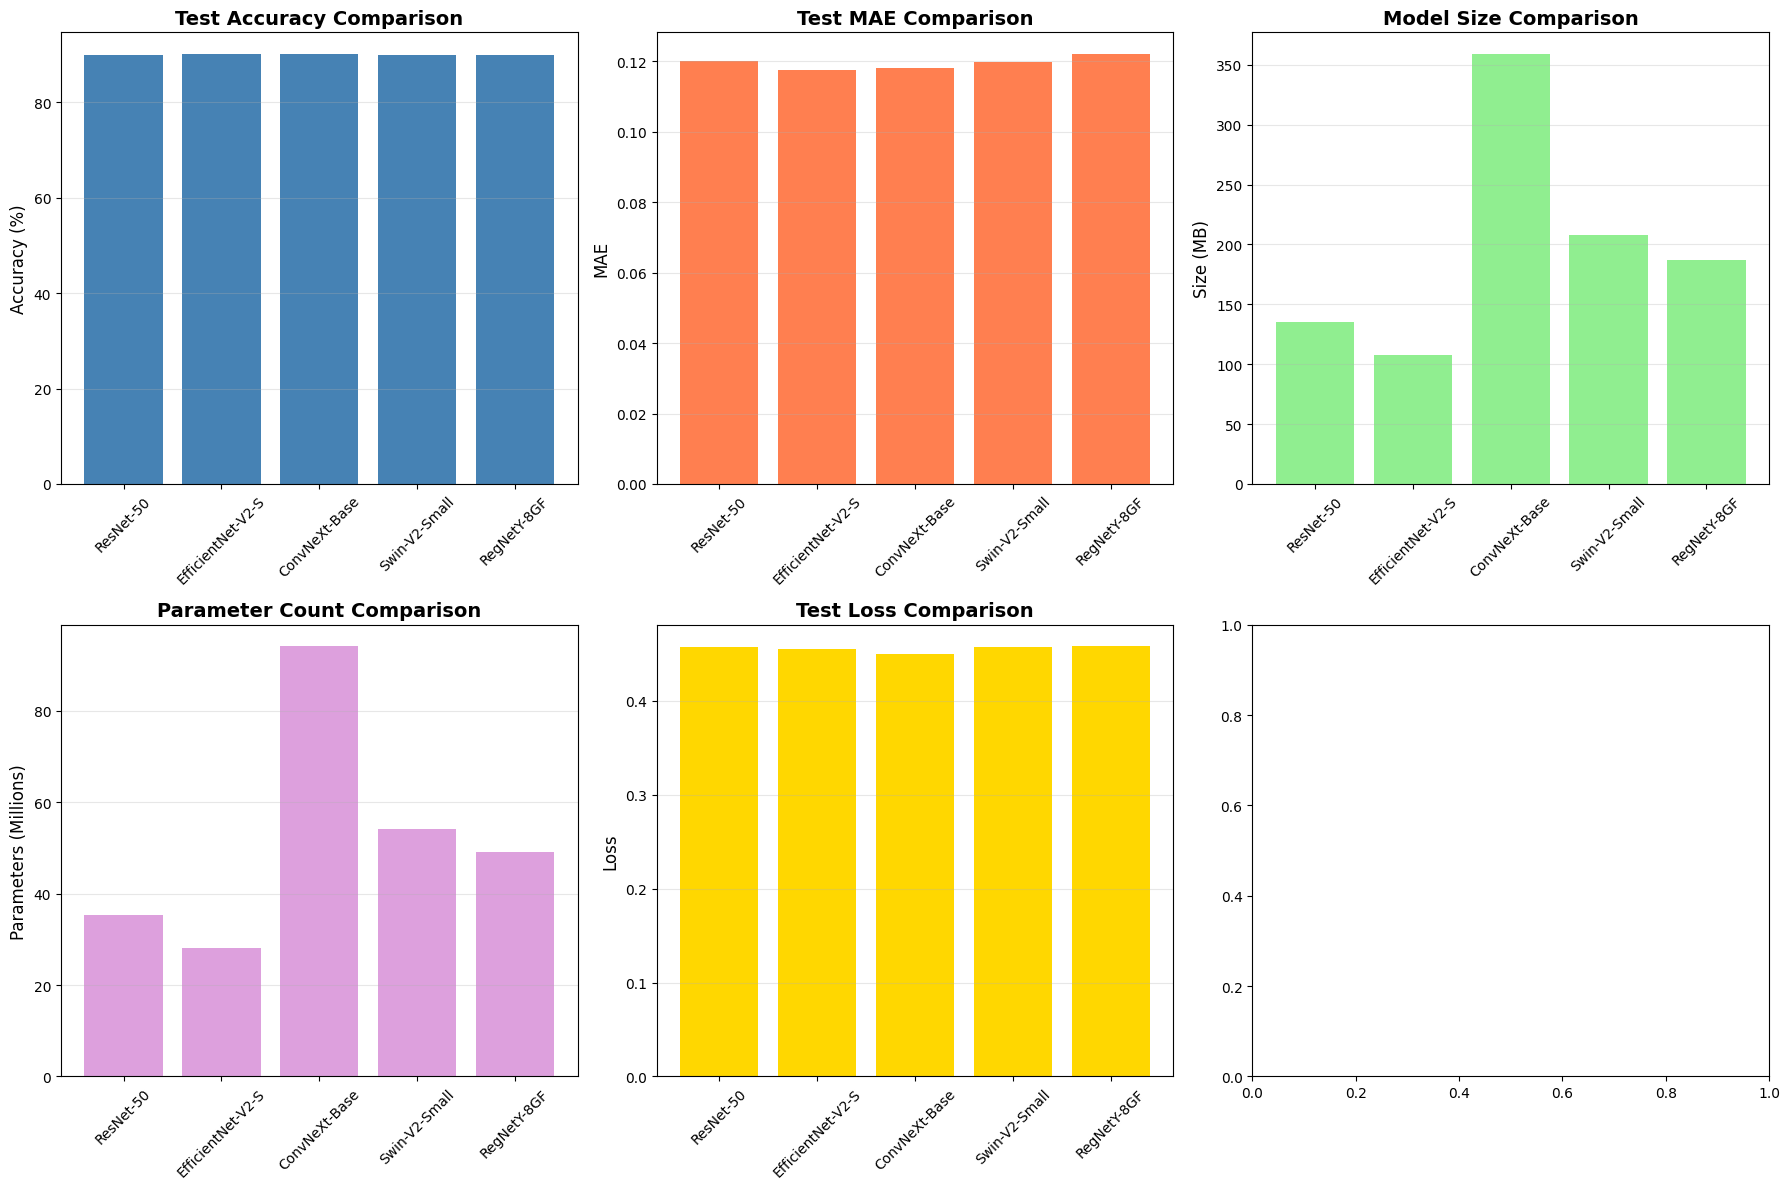

Comparison plot saved to results/model_comparison/model_comparison.png


In [32]:
# ============================================================
# COMPREHENSIVE MODEL COMPARISON
# ============================================================

# Create comparison directory
comparison_dir = RESULTS_DIR / 'model_comparison'
comparison_dir.mkdir(exist_ok=True)

# Collect all metrics
all_models_metrics = [
    resnet50_metrics,
    efficientnet_metrics,
    convnext_metrics,
    swin_metrics,
    regnet_metrics
]

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': m['model_name'],
        'Parameters (M)': m['total_params'] / 1e6,
        'Model Size (MB)': m['model_size_mb'],
        'Training Time (min)': m['training_time_minutes'],
        'Epochs': m['epochs_trained'],
        'Best Val Loss': m['best_val_loss'],
        'Test Loss': m['test_loss'],
        'Test MSE': m['test_mse'],
        'Test MAE': m['test_mae'],
        'Test Accuracy (%)': m['test_accuracy']
    }
    for m in all_models_metrics
])

print("="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Save comparison table
comparison_df.to_csv(comparison_dir / 'comparison_table.csv', index=False)
print(f"\nComparison table saved to {comparison_dir / 'comparison_table.csv'}")

# Visualization: Performance comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Test Accuracy comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test Accuracy (%)'], color='steelblue')
axes[0, 0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Test MAE comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['Test MAE'], color='coral')
axes[0, 1].set_title('Test MAE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('MAE', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Model size comparison
axes[0, 2].bar(comparison_df['Model'], comparison_df['Model Size (MB)'], color='lightgreen')
axes[0, 2].set_title('Model Size Comparison', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('Size (MB)', fontsize=12)
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Parameters comparison
axes[1, 0].bar(comparison_df['Model'], comparison_df['Parameters (M)'], color='plum')
axes[1, 0].set_title('Parameter Count Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Parameters (Millions)', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Test Loss comparison
axes[1, 1].bar(comparison_df['Model'], comparison_df['Test Loss'], color='gold')
axes[1, 1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Loss', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(comparison_dir / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Comparison plot saved to {comparison_dir / 'model_comparison.png'}")

## Cell 31: Per-Task Comparison


PER-TASK PERFORMANCE COMPARISON

PER-TASK MAE:
                   Task  ResNet-50  EfficientNet-V2-S  ConvNeXt-Base  Swin-V2-Small  RegNetY-8GF
task_01_smooth_features   0.072040           0.071069       0.071099       0.072495     0.077726
         task_02_edgeon   0.074819           0.069580       0.072035       0.068048     0.071015
            task_03_bar   0.208485           0.207559       0.199048       0.200500     0.211286
         task_04_spiral   0.220608           0.213338       0.211559       0.222557     0.220502
          task_05_bulge   0.122985           0.122143       0.124565       0.122244     0.123611
            task_06_odd   0.087979           0.086564       0.081456       0.088243     0.088958
      task_07_roundness   0.098819           0.094690       0.089244       0.098670     0.099219
    task_08_bulge_shape   0.147969           0.141811       0.147366       0.145927     0.152664
    task_09_arm_winding   0.140859           0.141391       0.140677       0.14

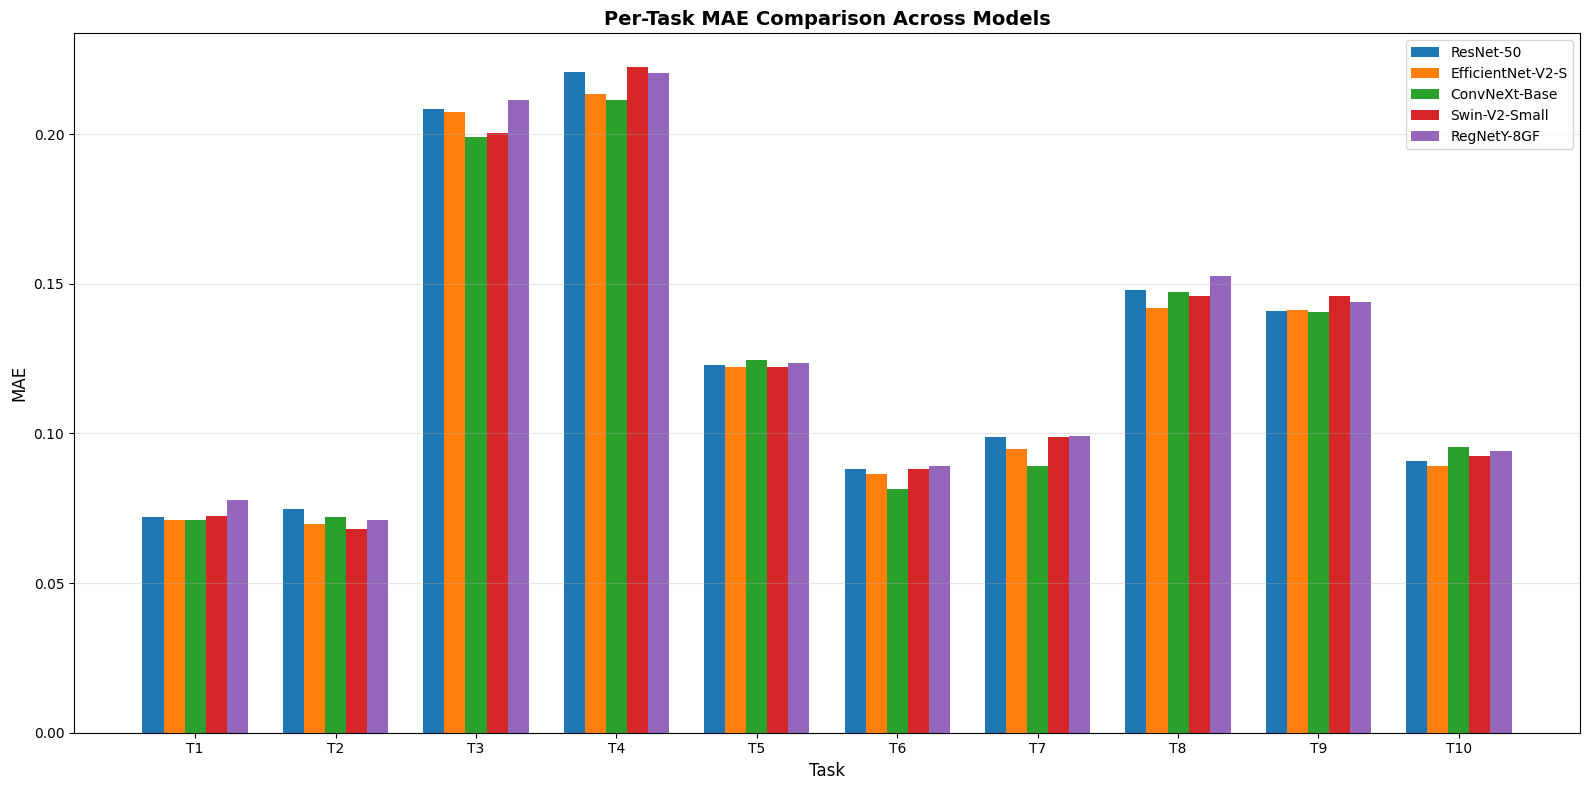

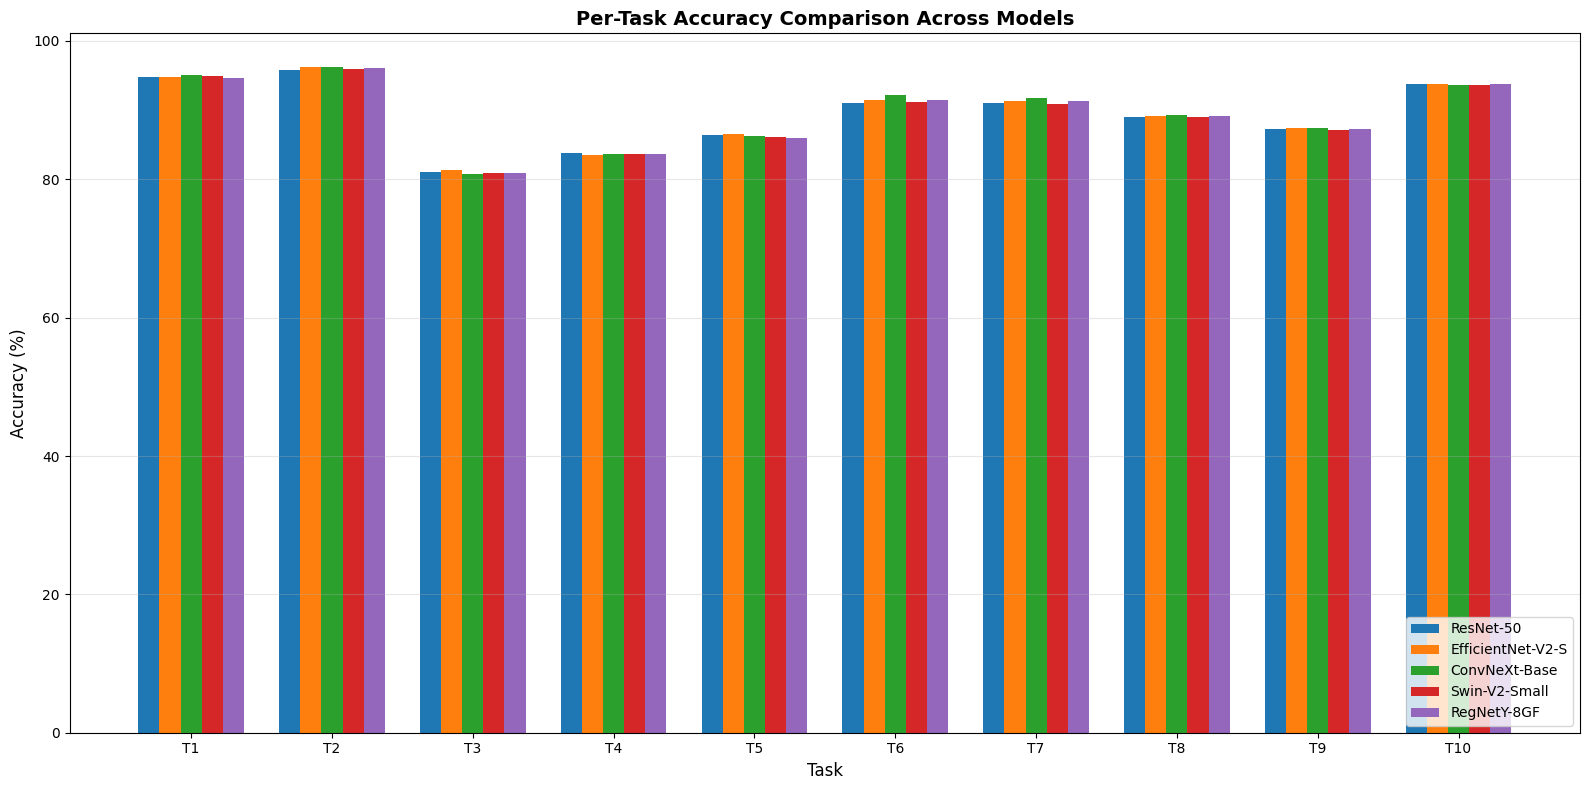

Per-task plots saved to results/model_comparison/


In [33]:
# ============================================================
# PER-TASK PERFORMANCE COMPARISON (MAE & ACCURACY)
# ============================================================

print("\n" + "="*80)
print("PER-TASK PERFORMANCE COMPARISON")
print("="*80)

# Create per-task comparison DataFrames
task_mae_data = []
task_acc_data = []

for task_name in TASK_METADATA.keys():
    mae_row = {'Task': task_name}
    acc_row = {'Task': task_name}
    for model_metrics in all_models_metrics:
        mae = model_metrics['task_metrics'][task_name]['mae']
        accuracy = model_metrics['task_metrics'][task_name]['accuracy']
        mae_row[model_metrics['model_name']] = mae
        acc_row[model_metrics['model_name']] = accuracy
    task_mae_data.append(mae_row)
    task_acc_data.append(acc_row)

task_mae_df = pd.DataFrame(task_mae_data)
task_acc_df = pd.DataFrame(task_acc_data)

print("\nPER-TASK MAE:")
print(task_mae_df.to_string(index=False))

print("\n" + "="*80)
print("\nPER-TASK ACCURACY (%):")
print(task_acc_df.to_string(index=False))

# Save per-task comparisons
task_mae_df.to_csv(comparison_dir / 'per_task_mae_comparison.csv', index=False)
task_acc_df.to_csv(comparison_dir / 'per_task_accuracy_comparison.csv', index=False)
print(f"\nPer-task comparisons saved to {comparison_dir}/")

# Visualize per-task MAE comparison
fig, ax = plt.subplots(figsize=(16, 8))
x = np.arange(len(TASK_METADATA))
width = 0.15

for i, model_metrics in enumerate(all_models_metrics):
    maes = [model_metrics['task_metrics'][task]['mae'] for task in TASK_METADATA.keys()]
    ax.bar(x + i*width, maes, width, label=model_metrics['model_name'])

ax.set_xlabel('Task', fontsize=12)
ax.set_ylabel('MAE', fontsize=12)
ax.set_title('Per-Task MAE Comparison Across Models', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels([f"T{i+1}" for i in range(len(TASK_METADATA))], rotation=0)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(comparison_dir / 'per_task_mae_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualize per-task Accuracy comparison
fig, ax = plt.subplots(figsize=(16, 8))
x = np.arange(len(TASK_METADATA))
width = 0.15

for i, model_metrics in enumerate(all_models_metrics):
    accuracies = [model_metrics['task_metrics'][task]['accuracy'] for task in TASK_METADATA.keys()]
    ax.bar(x + i*width, accuracies, width, label=model_metrics['model_name'])

ax.set_xlabel('Task', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Task Accuracy Comparison Across Models', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels([f"T{i+1}" for i in range(len(TASK_METADATA))], rotation=0)
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(comparison_dir / 'per_task_accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Per-task plots saved to {comparison_dir}/")

## Cell 32: Best Model Recommendations

In [34]:
# ============================================================
# RECOMMENDATIONS AND SUMMARY
# ============================================================

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

best_accuracy_idx = comparison_df['Test Accuracy (%)'].idxmax()
best_accuracy = comparison_df.loc[best_accuracy_idx, 'Model']
best_accuracy_val = comparison_df.loc[best_accuracy_idx, 'Test Accuracy (%)']

best_mae_idx = comparison_df['Test MAE'].idxmin()
best_mae = comparison_df.loc[best_mae_idx, 'Model']
best_mae_val = comparison_df.loc[best_mae_idx, 'Test MAE']

best_speed_idx = comparison_df['Training Time (min)'].idxmin()
best_speed = comparison_df.loc[best_speed_idx, 'Model']
best_speed_time = comparison_df.loc[best_speed_idx, 'Training Time (min)']

best_size_idx = comparison_df['Model Size (MB)'].idxmin()
best_size = comparison_df.loc[best_size_idx, 'Model']
best_size_mb = comparison_df.loc[best_size_idx, 'Model Size (MB)']

best_efficiency_idx = comparison_df['Parameters (M)'].idxmin()
best_efficiency = comparison_df.loc[best_efficiency_idx, 'Model']
best_efficiency_params = comparison_df.loc[best_efficiency_idx, 'Parameters (M)']

print(f"\n🏆 Best Accuracy: {best_accuracy}")
print(f"   Test Accuracy: {best_accuracy_val:.2f}%")

print(f"\n📊 Best MAE: {best_mae}")
print(f"   Test MAE: {best_mae_val:.6f}")

print(f"\n💾 Smallest Model Size: {best_size}")
print(f"   Model Size: {best_size_mb:.2f} MB")

print(f"\n⚙️ Most Parameter Efficient: {best_efficiency}")
print(f"   Parameters: {best_efficiency_params:.2f}M")

# Calculate accuracy-speed tradeoff
comparison_df['Accuracy-Speed Score'] = (
    (comparison_df['Test Accuracy (%)'] - comparison_df['Test Accuracy (%)'].min()) / 
    (comparison_df['Test Accuracy (%)'].max() - comparison_df['Test Accuracy (%)'].min()) * 0.7 +
    (1 - (comparison_df['Training Time (min)'] - comparison_df['Training Time (min)'].min()) / 
     (comparison_df['Training Time (min)'].max() - comparison_df['Training Time (min)'].min())) * 0.3
)

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\nTotal models trained: {len(all_models_metrics)}")
print(f"Total tasks: {len(TASK_METADATA)}")
print(f"Dataset size: {len(df_shuffled)} samples")
print(f"Training data: {len(train_df)} samples")
print(f"Validation data: {len(val_df)} samples")
print(f"Test data: {len(test_df)} samples")

print("\n" + "="*80)
print("ALL RESULTS SAVED TO:")
print(f"  - {RESULTS_DIR.absolute()}")
print(f"  - {comparison_dir.absolute()}")
print("="*80)


RECOMMENDATIONS

🏆 Best Accuracy: ConvNeXt-Base
   Test Accuracy: 90.12%

📊 Best MAE: EfficientNet-V2-S
   Test MAE: 0.117441

💾 Smallest Model Size: EfficientNet-V2-S
   Model Size: 107.70 MB

⚙️ Most Parameter Efficient: EfficientNet-V2-S
   Parameters: 28.07M

SUMMARY

Total models trained: 5
Total tasks: 10
Dataset size: 31248 samples
Training data: 21873 samples
Validation data: 4687 samples
Test data: 4688 samples

ALL RESULTS SAVED TO:
  - /home/nnik345/Projects/College/Computer Vision/Galaxy Analysis/results
  - /home/nnik345/Projects/College/Computer Vision/Galaxy Analysis/results/model_comparison


## Cell 33: Ensemble Model Creation

In [35]:
# ============================================================
# ENSEMBLE MODEL
# ============================================================

class EnsembleModel:
    """
    Ensemble of multiple trained models for galaxy morphology prediction.
    Combines predictions using weighted averaging or voting.
    """
    def __init__(self, models, weights=None, method='average'):
        """
        Args:
            models: List of trained models
            weights: List of weights for each model (None for equal weights)
            method: 'average' or 'weighted_average'
        """
        self.models = models
        self.method = method
        
        if weights is None:
            # Equal weights
            self.weights = [1.0 / len(models)] * len(models)
        else:
            # Normalize weights
            total = sum(weights)
            self.weights = [w / total for w in weights]
        
        print(f"\nEnsemble Configuration:")
        print(f"  Number of models: {len(self.models)}")
        print(f"  Method: {self.method}")
        print(f"  Weights: {self.weights}")
    
    def predict(self, dataloader, device, task_metadata):
        """
        Make ensemble predictions on a dataset.
        """
        all_preds = []
        all_labels = []
        
        # Set all models to eval mode
        for model in self.models:
            model.eval()
        
        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc="Ensemble Predicting", leave=False):
                images = images.to(device)
                labels = labels.to(device)
                
                # Get predictions from each model
                model_predictions = []
                for model in self.models:
                    task_outputs = model(images)
                    
                    # Concatenate task outputs
                    batch_preds = []
                    for task_name in task_metadata.keys():
                        batch_preds.append(task_outputs[task_name])
                    batch_preds = torch.cat(batch_preds, dim=1)
                    model_predictions.append(batch_preds)
                
                # Combine predictions using weighted average
                ensemble_pred = torch.zeros_like(model_predictions[0])
                for i, pred in enumerate(model_predictions):
                    ensemble_pred += pred * self.weights[i]
                
                all_preds.append(ensemble_pred.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        
        return all_preds, all_labels

print("Ensemble model class defined.")

Ensemble model class defined.


## Cell 34: Create Ensemble with All 5 Models

In [36]:
# ============================================================
# CREATE ENSEMBLE MODEL
# ============================================================

# Ensure all models are loaded with best weights
print("\n" + "="*60)
print("LOADING ALL MODELS FOR ENSEMBLE")
print("="*60)

# Load ResNet-50
resnet50_model.load_state_dict(
    torch.load(RESNET50_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
               map_location=DEVICE)
)
print("✓ ResNet-50 loaded")

# Load EfficientNet-V2-S
efficientnet_model.load_state_dict(
    torch.load(EFFICIENTNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
               map_location=DEVICE)
)
print("✓ EfficientNet-V2-S loaded")

# Load ConvNeXt-Base
convnext_model.load_state_dict(
    torch.load(CONVNEXT_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
               map_location=DEVICE)
)
print("✓ ConvNeXt-Base loaded")

# Load Swin-V2-Small
swin_model.load_state_dict(
    torch.load(SWIN_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
               map_location=DEVICE)
)
print("✓ Swin-V2-Small loaded")

# Load RegNetY-8GF
regnet_model.load_state_dict(
    torch.load(REGNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth', 
               map_location=DEVICE)
)
print("✓ RegNetY-8GF loaded")

# Create ensemble - Method 1: Equal weights
print("\n" + "="*60)
print("CREATING ENSEMBLE (EQUAL WEIGHTS)")
print("="*60)

ensemble_equal = EnsembleModel(
    models=[resnet50_model, efficientnet_model, convnext_model, swin_model, regnet_model],
    weights=None,  # Equal weights
    method='average'
)

# Create ensemble - Method 2: Performance-weighted (based on test accuracy)
print("\n" + "="*60)
print("CREATING ENSEMBLE (ACCURACY-WEIGHTED)")
print("="*60)

# Use test accuracies as weights (higher accuracy = higher weight)
accuracy_weights = [
    resnet50_test_accuracy,
    efficientnet_test_accuracy,
    convnext_test_accuracy,
    swin_test_accuracy,
    regnet_test_accuracy
]

ensemble_weighted = EnsembleModel(
    models=[resnet50_model, efficientnet_model, convnext_model, swin_model, regnet_model],
    weights=accuracy_weights,
    method='weighted_average'
)

# Create ensemble - Method 3: Inverse MAE weighted (lower MAE = higher weight)
print("\n" + "="*60)
print("CREATING ENSEMBLE (INVERSE-MAE-WEIGHTED)")
print("="*60)

# Use inverse of MAE as weights (lower MAE = better = higher weight)
mae_weights = [
    1.0 / resnet50_test_mae,
    1.0 / efficientnet_test_mae,
    1.0 / convnext_test_mae,
    1.0 / swin_test_mae,
    1.0 / regnet_test_mae
]

ensemble_mae_weighted = EnsembleModel(
    models=[resnet50_model, efficientnet_model, convnext_model, swin_model, regnet_model],
    weights=mae_weights,
    method='weighted_average'
)

print("\n✓ All ensemble models created successfully!")


LOADING ALL MODELS FOR ENSEMBLE
✓ ResNet-50 loaded
✓ EfficientNet-V2-S loaded
✓ ConvNeXt-Base loaded
✓ Swin-V2-Small loaded
✓ RegNetY-8GF loaded

CREATING ENSEMBLE (EQUAL WEIGHTS)

Ensemble Configuration:
  Number of models: 5
  Method: average
  Weights: [0.2, 0.2, 0.2, 0.2, 0.2]

CREATING ENSEMBLE (ACCURACY-WEIGHTED)

Ensemble Configuration:
  Number of models: 5
  Method: weighted_average
  Weights: [np.float64(0.1999086402893163), np.float64(0.20018682902773036), np.float64(0.2003085366007865), np.float64(0.1997395141813032), np.float64(0.19985647990086364)]

CREATING ENSEMBLE (INVERSE-MAE-WEIGHTED)

Ensemble Configuration:
  Number of models: 5
  Method: weighted_average
  Weights: [0.19909170531491915, 0.2034169505635966, 0.20224067200211948, 0.1995898417500581, 0.19566083036930662]

✓ All ensemble models created successfully!


## Cell 35: Evaluate All Ensemble Methods

In [37]:
# ============================================================
# EVALUATE ENSEMBLE MODELS
# ============================================================

print("\n" + "="*60)
print("EVALUATING ENSEMBLE: EQUAL WEIGHTS")
print("="*60)

ensemble_equal_preds, ensemble_equal_labels = ensemble_equal.predict(
    resnet50_test_loader, DEVICE, TASK_METADATA
)

# Compute metrics
mask = ~np.isnan(ensemble_equal_labels)
ensemble_equal_mse = mean_squared_error(ensemble_equal_labels[mask], ensemble_equal_preds[mask])
ensemble_equal_mae = mean_absolute_error(ensemble_equal_labels[mask], ensemble_equal_preds[mask])

# Compute accuracy
rounded_preds = np.round(ensemble_equal_preds[mask])
rounded_labels = np.round(ensemble_equal_labels[mask])
correct = np.sum(rounded_preds == rounded_labels)
total = len(rounded_labels)
ensemble_equal_accuracy = (correct / total) * 100

print(f"\nEnsemble (Equal Weights) Test Metrics:")
print(f"  Test MSE:  {ensemble_equal_mse:.6f}")
print(f"  Test MAE:  {ensemble_equal_mae:.6f}")
print(f"  Test Accuracy: {ensemble_equal_accuracy:.2f}%")

# Evaluate accuracy-weighted ensemble
print("\n" + "="*60)
print("EVALUATING ENSEMBLE: ACCURACY-WEIGHTED")
print("="*60)

ensemble_weighted_preds, ensemble_weighted_labels = ensemble_weighted.predict(
    resnet50_test_loader, DEVICE, TASK_METADATA
)

mask = ~np.isnan(ensemble_weighted_labels)
ensemble_weighted_mse = mean_squared_error(ensemble_weighted_labels[mask], ensemble_weighted_preds[mask])
ensemble_weighted_mae = mean_absolute_error(ensemble_weighted_labels[mask], ensemble_weighted_preds[mask])

rounded_preds = np.round(ensemble_weighted_preds[mask])
rounded_labels = np.round(ensemble_weighted_labels[mask])
correct = np.sum(rounded_preds == rounded_labels)
total = len(rounded_labels)
ensemble_weighted_accuracy = (correct / total) * 100

print(f"\nEnsemble (Accuracy-Weighted) Test Metrics:")
print(f"  Test MSE:  {ensemble_weighted_mse:.6f}")
print(f"  Test MAE:  {ensemble_weighted_mae:.6f}")
print(f"  Test Accuracy: {ensemble_weighted_accuracy:.2f}%")

# Evaluate MAE-weighted ensemble
print("\n" + "="*60)
print("EVALUATING ENSEMBLE: INVERSE-MAE-WEIGHTED")
print("="*60)

ensemble_mae_weighted_preds, ensemble_mae_weighted_labels = ensemble_mae_weighted.predict(
    resnet50_test_loader, DEVICE, TASK_METADATA
)

mask = ~np.isnan(ensemble_mae_weighted_labels)
ensemble_mae_weighted_mse = mean_squared_error(ensemble_mae_weighted_labels[mask], ensemble_mae_weighted_preds[mask])
ensemble_mae_weighted_mae = mean_absolute_error(ensemble_mae_weighted_labels[mask], ensemble_mae_weighted_preds[mask])

rounded_preds = np.round(ensemble_mae_weighted_preds[mask])
rounded_labels = np.round(ensemble_mae_weighted_labels[mask])
correct = np.sum(rounded_preds == rounded_labels)
total = len(rounded_labels)
ensemble_mae_weighted_accuracy = (correct / total) * 100

print(f"\nEnsemble (Inverse-MAE-Weighted) Test Metrics:")
print(f"  Test MSE:  {ensemble_mae_weighted_mse:.6f}")
print(f"  Test MAE:  {ensemble_mae_weighted_mae:.6f}")
print(f"  Test Accuracy: {ensemble_mae_weighted_accuracy:.2f}%")

# Per-task metrics for best ensemble (use equal weights for now)
ensemble_task_metrics = compute_per_task_metrics(ensemble_equal_preds, ensemble_equal_labels, TASK_METADATA)

print("\n" + "="*60)
print("ENSEMBLE (EQUAL WEIGHTS) PER-TASK METRICS")
print("="*60)
for task_name, metrics in ensemble_task_metrics.items():
    print(f"\n{task_name}:")
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  MAE: {metrics['mae']:.6f}")
    print(f"  Accuracy: {metrics['accuracy']:.2f}%")


EVALUATING ENSEMBLE: EQUAL WEIGHTS



Ensemble (Equal Weights) Test Metrics:
  Test MSE:  0.041083
  Test MAE:  0.116513
  Test Accuracy: 90.49%

EVALUATING ENSEMBLE: ACCURACY-WEIGHTED



Ensemble (Accuracy-Weighted) Test Metrics:
  Test MSE:  0.041083
  Test MAE:  0.116512
  Test Accuracy: 90.49%

EVALUATING ENSEMBLE: INVERSE-MAE-WEIGHTED



Ensemble (Inverse-MAE-Weighted) Test Metrics:
  Test MSE:  0.041081
  Test MAE:  0.116491
  Test Accuracy: 90.49%

ENSEMBLE (EQUAL WEIGHTS) PER-TASK METRICS

task_01_smooth_features:
  MSE: 0.020044
  MAE: 0.070819
  Accuracy: 95.15%

task_02_edgeon:
  MSE: 0.019521
  MAE: 0.068381
  Accuracy: 96.34%

task_03_bar:
  MSE: 0.071097
  MAE: 0.201123
  Accuracy: 81.83%

task_04_spiral:
  MSE: 0.098250
  MAE: 0.215952
  Accuracy: 84.37%

task_05_bulge:
  MSE: 0.038078
  MAE: 0.120704
  Accuracy: 86.77%

task_06_odd:
  MSE: 0.011617
  MAE: 0.078750
  Accuracy: 92.39%

task_07_roundness:
  MSE: 0.022804
  MAE: 0.089134
  Accuracy: 92.13%

task_08_bulge_shape:
  MSE: 0.065105
  MAE: 0.146493
  Accuracy: 89.47%

task_09_arm_winding:
  MSE: 0.054332
  MAE: 0.140138
  Accuracy: 87.95%

task_10_arm_number:
  MSE: 0.032063
  MAE: 0.090745
  Accuracy: 93.93%


## Cell 36: Compare Ensemble vs Individual Models


ENSEMBLE VS INDIVIDUAL MODELS COMPARISON
                  Model       Type  Test Accuracy (%)  Test MAE  Test MSE
              ResNet-50 Individual          89.938417  0.119992  0.043310
      EfficientNet-V2-S Individual          90.063574  0.117441  0.042984
          ConvNeXt-Base Individual          90.118330  0.118124  0.042642
          Swin-V2-Small Individual          89.862328  0.119693  0.043330
            RegNetY-8GF Individual          89.914951  0.122096  0.043339
       Ensemble (Equal)   Ensemble          90.486688  0.116513  0.041083
Ensemble (Acc-Weighted)   Ensemble          90.486688  0.116512  0.041083
Ensemble (MAE-Weighted)   Ensemble          90.488110  0.116491  0.041081

Ensemble comparison saved to results/model_comparison/ensemble_comparison.csv


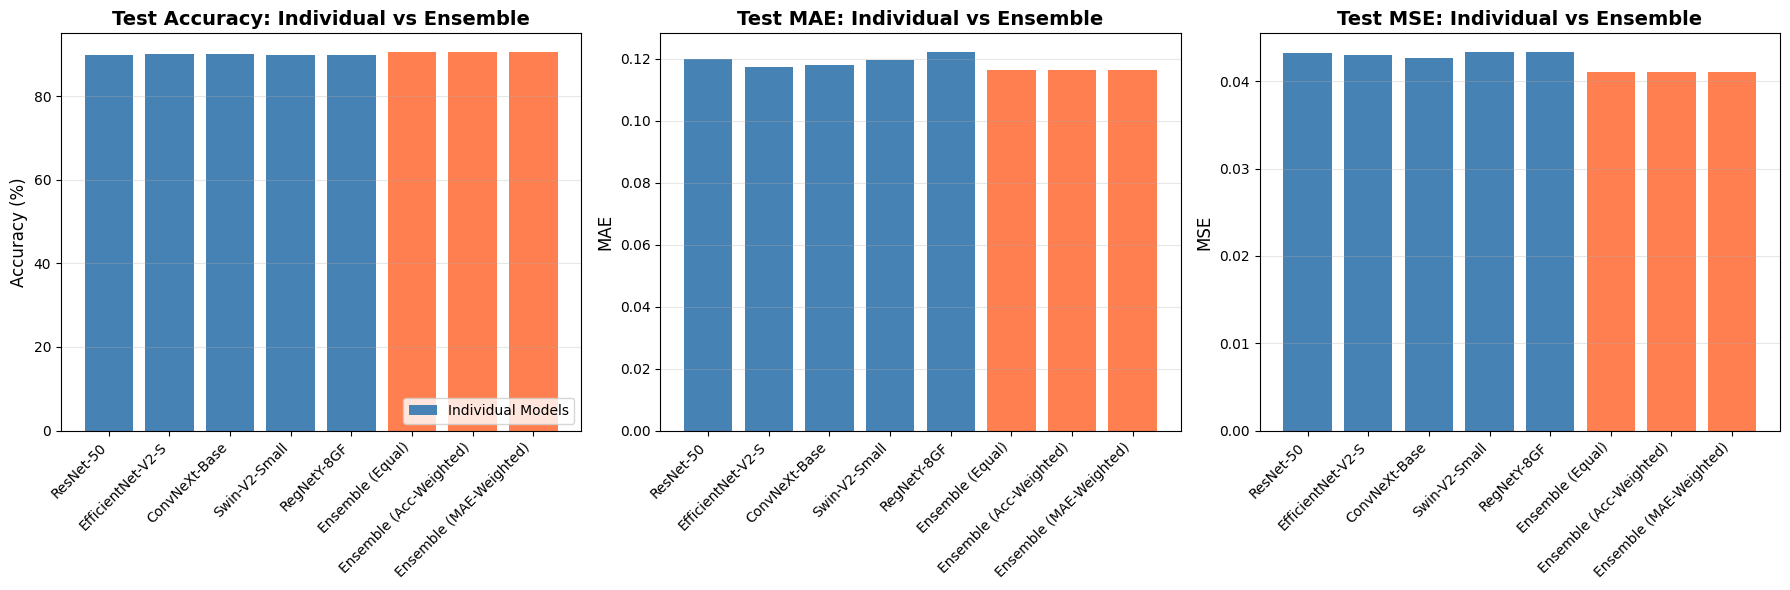

Ensemble comparison plot saved to results/model_comparison/ensemble_vs_individual_comparison.png

BEST MODELS

🏆 Best Individual Model: ConvNeXt-Base
   Accuracy: 90.12%

🏆 Best Ensemble Model: Ensemble (MAE-Weighted)
   Accuracy: 90.49%

✨ Ensemble improves over best individual by 0.37%


In [38]:
# ============================================================
# COMPARISON: ENSEMBLE VS INDIVIDUAL MODELS
# ============================================================

# Create comprehensive comparison
ensemble_comparison_data = []

# Add individual models
for model_metrics in all_models_metrics:
    ensemble_comparison_data.append({
        'Model': model_metrics['model_name'],
        'Type': 'Individual',
        'Test Accuracy (%)': model_metrics['test_accuracy'],
        'Test MAE': model_metrics['test_mae'],
        'Test MSE': model_metrics['test_mse']
    })

# Add ensemble models
ensemble_comparison_data.append({
    'Model': 'Ensemble (Equal)',
    'Type': 'Ensemble',
    'Test Accuracy (%)': ensemble_equal_accuracy,
    'Test MAE': ensemble_equal_mae,
    'Test MSE': ensemble_equal_mse
})

ensemble_comparison_data.append({
    'Model': 'Ensemble (Acc-Weighted)',
    'Type': 'Ensemble',
    'Test Accuracy (%)': ensemble_weighted_accuracy,
    'Test MAE': ensemble_weighted_mae,
    'Test MSE': ensemble_weighted_mse
})

ensemble_comparison_data.append({
    'Model': 'Ensemble (MAE-Weighted)',
    'Type': 'Ensemble',
    'Test Accuracy (%)': ensemble_mae_weighted_accuracy,
    'Test MAE': ensemble_mae_weighted_mae,
    'Test MSE': ensemble_mae_weighted_mse
})

ensemble_comparison_df = pd.DataFrame(ensemble_comparison_data)

print("\n" + "="*80)
print("ENSEMBLE VS INDIVIDUAL MODELS COMPARISON")
print("="*80)
print(ensemble_comparison_df.to_string(index=False))
print("="*80)

# Save comparison
ensemble_comparison_df.to_csv(comparison_dir / 'ensemble_comparison.csv', index=False)
print(f"\nEnsemble comparison saved to {comparison_dir / 'ensemble_comparison.csv'}")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Accuracy comparison
models = ensemble_comparison_df['Model']
accuracies = ensemble_comparison_df['Test Accuracy (%)']
colors = ['steelblue' if t == 'Individual' else 'coral' for t in ensemble_comparison_df['Type']]

axes[0].bar(range(len(models)), accuracies, color=colors)
axes[0].set_xticks(range(len(models)))
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Test Accuracy: Individual vs Ensemble', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend(['Individual Models', 'Ensemble Models'], loc='lower right')

# MAE comparison
mae_values = ensemble_comparison_df['Test MAE']
axes[1].bar(range(len(models)), mae_values, color=colors)
axes[1].set_xticks(range(len(models)))
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Test MAE: Individual vs Ensemble', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# MSE comparison
mse_values = ensemble_comparison_df['Test MSE']
axes[2].bar(range(len(models)), mse_values, color=colors)
axes[2].set_xticks(range(len(models)))
axes[2].set_xticklabels(models, rotation=45, ha='right')
axes[2].set_ylabel('MSE', fontsize=12)
axes[2].set_title('Test MSE: Individual vs Ensemble', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(comparison_dir / 'ensemble_vs_individual_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Ensemble comparison plot saved to {comparison_dir / 'ensemble_vs_individual_comparison.png'}")

# Highlight best model
best_individual_idx = ensemble_comparison_df[ensemble_comparison_df['Type'] == 'Individual']['Test Accuracy (%)'].idxmax()
best_individual = ensemble_comparison_df.loc[best_individual_idx, 'Model']
best_individual_acc = ensemble_comparison_df.loc[best_individual_idx, 'Test Accuracy (%)']

best_ensemble_idx = ensemble_comparison_df[ensemble_comparison_df['Type'] == 'Ensemble']['Test Accuracy (%)'].idxmax()
best_ensemble = ensemble_comparison_df.loc[best_ensemble_idx, 'Model']
best_ensemble_acc = ensemble_comparison_df.loc[best_ensemble_idx, 'Test Accuracy (%)']

print("\n" + "="*80)
print("BEST MODELS")
print("="*80)
print(f"\n🏆 Best Individual Model: {best_individual}")
print(f"   Accuracy: {best_individual_acc:.2f}%")
print(f"\n🏆 Best Ensemble Model: {best_ensemble}")
print(f"   Accuracy: {best_ensemble_acc:.2f}%")

if best_ensemble_acc > best_individual_acc:
    improvement = best_ensemble_acc - best_individual_acc
    print(f"\n✨ Ensemble improves over best individual by {improvement:.2f}%")
else:
    print(f"\n⚠️ Best individual model outperforms ensemble")

print("="*80)

## Cell 37: Save Ensemble Model

In [39]:
# ============================================================
# SAVE BEST ENSEMBLE MODEL
# ============================================================

# Determine which ensemble performed best
ensemble_methods = {
    'equal': (ensemble_equal_accuracy, ensemble_equal_mae, ensemble_equal_mse),
    'accuracy_weighted': (ensemble_weighted_accuracy, ensemble_weighted_mae, ensemble_weighted_mse),
    'mae_weighted': (ensemble_mae_weighted_accuracy, ensemble_mae_weighted_mae, ensemble_mae_weighted_mse)
}

best_ensemble_method = max(ensemble_methods.items(), key=lambda x: x[1][0])
best_method_name = best_ensemble_method[0]
best_method_acc, best_method_mae, best_method_mse = best_ensemble_method[1]

print(f"\n{'='*60}")
print(f"SAVING BEST ENSEMBLE MODEL")
print(f"{'='*60}")
print(f"Best ensemble method: {best_method_name}")
print(f"  Accuracy: {best_method_acc:.2f}%")
print(f"  MAE: {best_method_mae:.6f}")
print(f"  MSE: {best_method_mse:.6f}")

# Save ensemble configuration
ensemble_dir = RESULTS_DIR / 'ensemble'
ensemble_dir.mkdir(exist_ok=True)

ensemble_config = {
    'method': best_method_name,
    'models': [
        'resnet50',
        'efficientnet_v2_s',
        'convnext_base',
        'swin_v2_small',
        'regnet_y_8gf'
    ],
    'weights': {
        'equal': [0.2, 0.2, 0.2, 0.2, 0.2],
        'accuracy_weighted': [w for w in ensemble_weighted.weights],
        'mae_weighted': [w for w in ensemble_mae_weighted.weights]
    },
    'test_accuracy': best_method_acc,
    'test_mae': best_method_mae,
    'test_mse': best_method_mse,
    'task_metrics': {k: {'mse': float(v['mse']), 'mae': float(v['mae']), 'accuracy': float(v['accuracy'])} 
                     for k, v in ensemble_task_metrics.items()}
}

with open(ensemble_dir / 'ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f, indent=2)

print(f"\n✓ Ensemble configuration saved to {ensemble_dir / 'ensemble_config.json'}")

# Save paths to individual model weights
model_paths = {
    'resnet50': str(RESNET50_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth'),
    'efficientnet_v2_s': str(EFFICIENTNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth'),
    'convnext_base': str(CONVNEXT_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth'),
    'swin_v2_small': str(SWIN_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth'),
    'regnet_y_8gf': str(REGNET_CONFIG['output_dir'] / 'checkpoints' / 'best_model.pth')
}

with open(ensemble_dir / 'model_paths.json', 'w') as f:
    json.dump(model_paths, f, indent=2)

print(f"✓ Model paths saved to {ensemble_dir / 'model_paths.json'}")

print(f"\n{'='*60}")
print(f"ENSEMBLE MODEL COMPLETE")
print(f"{'='*60}")


SAVING BEST ENSEMBLE MODEL
Best ensemble method: mae_weighted
  Accuracy: 90.49%
  MAE: 0.116491
  MSE: 0.041081

✓ Ensemble configuration saved to results/ensemble/ensemble_config.json
✓ Model paths saved to results/ensemble/model_paths.json

ENSEMBLE MODEL COMPLETE


## Cell 38: Import and Check XGBoost/LightGBM

In [40]:
# ============================================================
# IMPORT AND CHECK XGBOOST/LIGHTGBM
# ============================================================

import xgboost as xgb
import lightgbm as lgb
import pickle

print("="*60)
print("CHECKING XGBOOST AND LIGHTGBM")
print("="*60)

print(f"\n✓ XGBoost version: {xgb.__version__}")
print(f"✓ LightGBM version: {lgb.__version__}")

# Check GPU support for XGBoost
try:
    test_model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    print("✓ XGBoost GPU support: Available")
except:
    print("✓ XGBoost GPU support: Not available (will use CPU)")

# Check GPU support for LightGBM
try:
    test_data = lgb.Dataset(np.random.rand(100, 10), np.random.rand(100))
    test_params = {'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
    lgb.train(test_params, test_data, num_boost_round=1, verbose_eval=False)
    print("✓ LightGBM GPU support: Available")
except:
    print("✓ LightGBM GPU support: Not available (will use CPU)")

print("="*60)

CHECKING XGBOOST AND LIGHTGBM

✓ XGBoost version: 3.2.0
✓ LightGBM version: 4.6.0
✓ XGBoost GPU support: Available
✓ LightGBM GPU support: Not available (will use CPU)


## Cell 39: Extract Features from All Models

In [41]:
# ============================================================
# EXTRACT FEATURES FROM CNN BACKBONES
# ============================================================

def extract_features_from_backbone(model, dataloader, device):
    """Extract features from CNN backbone (before task heads)."""
    model.eval()
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features", leave=False):
            images = images.to(device)
            features = model.backbone(images)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    return np.vstack(all_features), np.vstack(all_labels)

print("\n" + "="*60)
print("EXTRACTING FEATURES FROM ALL CNN BACKBONES")
print("="*60)

# Dictionary to store features from each backbone
all_extracted_features = {}

# Extract from ResNet-50
print("\nResNet-50:")
train_feat, train_lab = extract_features_from_backbone(resnet50_model, resnet50_train_loader, DEVICE)
val_feat, val_lab = extract_features_from_backbone(resnet50_model, resnet50_val_loader, DEVICE)
test_feat, test_lab = extract_features_from_backbone(resnet50_model, resnet50_test_loader, DEVICE)
all_extracted_features['resnet50'] = {
    'train': (train_feat, train_lab),
    'val': (val_feat, val_lab),
    'test': (test_feat, test_lab)
}
print(f"  Train: {train_feat.shape}, Val: {val_feat.shape}, Test: {test_feat.shape}")

# Extract from EfficientNet-V2-S
print("\nEfficientNet-V2-S:")
train_feat, train_lab = extract_features_from_backbone(efficientnet_model, efficientnet_train_loader, DEVICE)
val_feat, val_lab = extract_features_from_backbone(efficientnet_model, efficientnet_val_loader, DEVICE)
test_feat, test_lab = extract_features_from_backbone(efficientnet_model, efficientnet_test_loader, DEVICE)
all_extracted_features['efficientnet'] = {
    'train': (train_feat, train_lab),
    'val': (val_feat, val_lab),
    'test': (test_feat, test_lab)
}
print(f"  Train: {train_feat.shape}, Val: {val_feat.shape}, Test: {test_feat.shape}")

# Extract from ConvNeXt-Base
print("\nConvNeXt-Base:")
train_feat, train_lab = extract_features_from_backbone(convnext_model, convnext_train_loader, DEVICE)
val_feat, val_lab = extract_features_from_backbone(convnext_model, convnext_val_loader, DEVICE)
test_feat, test_lab = extract_features_from_backbone(convnext_model, convnext_test_loader, DEVICE)
all_extracted_features['convnext'] = {
    'train': (train_feat, train_lab),
    'val': (val_feat, val_lab),
    'test': (test_feat, test_lab)
}
print(f"  Train: {train_feat.shape}, Val: {val_feat.shape}, Test: {test_feat.shape}")

# Extract from Swin-V2-Small
print("\nSwin-V2-Small:")
train_feat, train_lab = extract_features_from_backbone(swin_model, swin_train_loader, DEVICE)
val_feat, val_lab = extract_features_from_backbone(swin_model, swin_val_loader, DEVICE)
test_feat, test_lab = extract_features_from_backbone(swin_model, swin_test_loader, DEVICE)
all_extracted_features['swin'] = {
    'train': (train_feat, train_lab),
    'val': (val_feat, val_lab),
    'test': (test_feat, test_lab)
}
print(f"  Train: {train_feat.shape}, Val: {val_feat.shape}, Test: {test_feat.shape}")

# Extract from RegNetY-8GF
print("\nRegNetY-8GF:")
train_feat, train_lab = extract_features_from_backbone(regnet_model, regnet_train_loader, DEVICE)
val_feat, val_lab = extract_features_from_backbone(regnet_model, regnet_val_loader, DEVICE)
test_feat, test_lab = extract_features_from_backbone(regnet_model, regnet_test_loader, DEVICE)
all_extracted_features['regnet'] = {
    'train': (train_feat, train_lab),
    'val': (val_feat, val_lab),
    'test': (test_feat, test_lab)
}
print(f"  Train: {train_feat.shape}, Val: {val_feat.shape}, Test: {test_feat.shape}")

print("\n✓ Feature extraction complete for all backbones!")


EXTRACTING FEATURES FROM ALL CNN BACKBONES

ResNet-50:


  Train: (21873, 2048), Val: (4687, 2048), Test: (4688, 2048)

EfficientNet-V2-S:


  Train: (21873, 1280), Val: (4687, 1280), Test: (4688, 1280)

ConvNeXt-Base:


  Train: (21873, 1024), Val: (4687, 1024), Test: (4688, 1024)

Swin-V2-Small:


  Train: (21873, 768), Val: (4687, 768), Test: (4688, 768)

RegNetY-8GF:


  Train: (21873, 2016), Val: (4687, 2016), Test: (4688, 2016)

✓ Feature extraction complete for all backbones!


## Cell 39: XGBoost Configuration for Each Backbone

In [42]:
# ============================================================
# XGBOOST CONFIGURATIONS (One per backbone)
# ============================================================

XGBOOST_CONFIGS = {}

for backbone_name in ['resnet50', 'efficientnet', 'convnext', 'swin', 'regnet']:
    XGBOOST_CONFIGS[backbone_name] = {
        'backbone_name': backbone_name,
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'output_dir': RESULTS_DIR / f'{backbone_name}_xgboost'
    }
    
    # Create directories
    XGBOOST_CONFIGS[backbone_name]['output_dir'].mkdir(exist_ok=True)
    (XGBOOST_CONFIGS[backbone_name]['output_dir'] / 'checkpoints').mkdir(exist_ok=True)

print("="*60)
print("XGBOOST CONFIGURATIONS")
print("="*60)
for name, config in XGBOOST_CONFIGS.items():
    print(f"{name}: {config['output_dir']}")
print("="*60)

# Check GPU support
import xgboost as xgb
try:
    test_model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    xgb_tree_method = 'gpu_hist'
    xgb_gpu_id = 0
    print("\n✓ XGBoost GPU support available")
except:
    xgb_tree_method = 'hist'
    xgb_gpu_id = None
    print("\n✓ XGBoost using CPU (fast histogram method)")

XGBOOST CONFIGURATIONS
resnet50: results/resnet50_xgboost
efficientnet: results/efficientnet_xgboost
convnext: results/convnext_xgboost
swin: results/swin_xgboost
regnet: results/regnet_xgboost

✓ XGBoost GPU support available


## Cell 41: XGBoost Configuration for Each Backbone

In [44]:
# ============================================================
# XGBOOST CONFIGURATIONS (One per backbone)
# ============================================================

XGBOOST_CONFIGS = {}

for backbone_name in ['resnet50', 'efficientnet', 'convnext', 'swin', 'regnet']:
    XGBOOST_CONFIGS[backbone_name] = {
        'backbone_name': backbone_name,
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'output_dir': RESULTS_DIR / f'{backbone_name}_xgboost'
    }
    
    # Create directories
    XGBOOST_CONFIGS[backbone_name]['output_dir'].mkdir(exist_ok=True)
    (XGBOOST_CONFIGS[backbone_name]['output_dir'] / 'checkpoints').mkdir(exist_ok=True)

print("="*60)
print("XGBOOST CONFIGURATIONS")
print("="*60)
for name, config in XGBOOST_CONFIGS.items():
    print(f"{name}: {config['output_dir']}")
print("="*60)

# Check GPU support (NEW API for XGBoost 3.1+)
import xgboost as xgb
try:
    test_model = xgb.XGBRegressor(device='cuda:0')  # CHANGED: use device instead of gpu_id
    xgb_device = 'cuda:0'
    print("\n✓ XGBoost GPU support available")
except:
    xgb_device = 'cpu'
    print("\n✓ XGBoost using CPU")

XGBOOST CONFIGURATIONS
resnet50: results/resnet50_xgboost
efficientnet: results/efficientnet_xgboost
convnext: results/convnext_xgboost
swin: results/swin_xgboost
regnet: results/regnet_xgboost

✓ XGBoost GPU support available


## Cell 42: Train All XGBoost Models

In [45]:
# ============================================================
# TRAIN XGBOOST MODELS FOR EACH BACKBONE
# ============================================================

import pickle

xgboost_all_results = {}

for backbone_name, config in XGBOOST_CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"XGBOOST WITH {backbone_name.upper()} FEATURES")
    print(f"{'='*60}")
    
    # Get features
    train_features, train_labels = all_extracted_features[backbone_name]['train']
    val_features, val_labels = all_extracted_features[backbone_name]['val']
    test_features, test_labels = all_extracted_features[backbone_name]['test']
    
    checkpoint_path = config['output_dir'] / 'checkpoints' / 'xgboost_models.pkl'
    skip_training = False
    models = []
    
    # Check for existing checkpoint
    if checkpoint_path.exists():
        print(f"Found checkpoint at {checkpoint_path}")
        user_choice = input("Resume (r), Restart (restart), or Skip (s)? ").strip().lower()
        
        if user_choice == 'r':
            if is_training_complete(config['output_dir']):
                print("Training already complete! Loading models...")
                with open(checkpoint_path, 'rb') as f:
                    models = pickle.load(f)
                skip_training = True
            else:
                print("No complete training found. Starting fresh...")
        elif user_choice == 'restart':
            print("Starting fresh training...")
            if checkpoint_path.exists():
                checkpoint_path.unlink()
            if is_training_complete(config['output_dir']):
                (config['output_dir'] / 'training_complete.txt').unlink()
        elif user_choice == 's':
            print("Skipping training...")
            skip_training = True
            if checkpoint_path.exists():
                with open(checkpoint_path, 'rb') as f:
                    models = pickle.load(f)
        else:
            print("Invalid choice. Starting fresh...")
    
    # Training
    if not skip_training:
        print("Training XGBoost models...")
        num_outputs = train_labels.shape[1]
        models = []
        
        xgb_params = {
            'objective': 'reg:squarederror',
            'device': xgb_device,
            'max_depth': config['max_depth'],
            'learning_rate': config['learning_rate'],
            'n_estimators': config['n_estimators'],
            'subsample': config['subsample'],
            'colsample_bytree': config['colsample_bytree'],
            'random_state': 42,
            'n_jobs': -1 if xgb_device == 'cpu' else 1
        }
        
        training_start = time.time()
        
        for i in tqdm(range(num_outputs), desc=f"Training {backbone_name}"):
            y_train = train_labels[:, i]
            y_val = val_labels[:, i]
            
            train_mask = ~np.isnan(y_train)
            val_mask = ~np.isnan(y_val)
            
            if train_mask.sum() == 0:
                models.append(None)
                continue
            
            model = xgb.XGBRegressor(**xgb_params)
            model.fit(
                train_features[train_mask],
                y_train[train_mask],
                eval_set=[(val_features[val_mask], y_val[val_mask])] if val_mask.sum() > 0 else None,
                verbose=False
            )
            models.append(model)
        
        training_time = time.time() - training_start
        
        # Save
        with open(checkpoint_path, 'wb') as f:
            pickle.dump(models, f)
        mark_training_complete(config['output_dir'])
        
        print(f"Training complete: {training_time/60:.1f} minutes")
    else:
        training_time = 0
    
    # Evaluate
    predictions = []
    for model in models:
        if model is None:
            predictions.append(np.full(len(test_features), np.nan))
        else:
            predictions.append(model.predict(test_features))
    predictions = np.column_stack(predictions)
    
    # Metrics
    mask = ~np.isnan(test_labels)
    test_mse = mean_squared_error(test_labels[mask], predictions[mask])
    test_mae = mean_absolute_error(test_labels[mask], predictions[mask])
    
    rounded_preds = np.round(predictions[mask])
    rounded_labels = np.round(test_labels[mask])
    test_accuracy = (np.sum(rounded_preds == rounded_labels) / len(rounded_labels)) * 100
    
    # Per-task metrics
    task_metrics = compute_per_task_metrics(predictions, test_labels, TASK_METADATA)
    
    print(f"\nTest Results:")
    print(f"  MSE: {test_mse:.6f}")
    print(f"  MAE: {test_mae:.6f}")
    print(f"  Accuracy: {test_accuracy:.2f}%")
    
    # Save metrics
    metrics = {
        'model_name': f'XGBoost ({backbone_name})',
        'backbone': backbone_name,
        'training_time_minutes': training_time / 60 if not skip_training else 0,
        'test_mse': test_mse,
        'test_mae': test_mae,
        'test_accuracy': test_accuracy,
        'task_metrics': {k: {'mse': float(v['mse']), 'mae': float(v['mae']), 'accuracy': float(v['accuracy'])} 
                         for k, v in task_metrics.items()}
    }
    
    with open(config['output_dir'] / 'metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    
    xgboost_all_results[backbone_name] = metrics

print("\n" + "="*60)
print("ALL XGBOOST MODELS COMPLETE")
print("="*60)


XGBOOST WITH RESNET50 FEATURES
Training XGBoost models...


Training resnet50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:37<00:00,  3.24s/it]


Training complete: 1.6 minutes

Test Results:
  MSE: 0.044367
  MAE: 0.120605
  Accuracy: 89.88%

XGBOOST WITH EFFICIENTNET FEATURES
Training XGBoost models...


Training efficientnet: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:19<00:00,  6.65s/it]


Training complete: 3.3 minutes

Test Results:
  MSE: 0.044095
  MAE: 0.119201
  Accuracy: 89.97%

XGBOOST WITH CONVNEXT FEATURES
Training XGBoost models...


Training convnext: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:41<00:00,  5.39s/it]


Training complete: 2.7 minutes

Test Results:
  MSE: 0.043483
  MAE: 0.117638
  Accuracy: 90.04%

XGBOOST WITH SWIN FEATURES
Training XGBoost models...


Training swin: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:58<00:00,  3.96s/it]


Training complete: 2.0 minutes

Test Results:
  MSE: 0.044277
  MAE: 0.120339
  Accuracy: 89.86%

XGBOOST WITH REGNET FEATURES
Training XGBoost models...


Training regnet: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:51<00:00,  3.71s/it]


Training complete: 1.9 minutes

Test Results:
  MSE: 0.044293
  MAE: 0.121779
  Accuracy: 89.84%

ALL XGBOOST MODELS COMPLETE


## Cell 43: LightGBM Configuration for Each Backbone

In [46]:
# ============================================================
# LIGHTGBM CONFIGURATIONS (One per backbone)
# ============================================================

LIGHTGBM_CONFIGS = {}

for backbone_name in ['resnet50', 'efficientnet', 'convnext', 'swin', 'regnet']:
    LIGHTGBM_CONFIGS[backbone_name] = {
        'backbone_name': backbone_name,
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'output_dir': RESULTS_DIR / f'{backbone_name}_lightgbm'
    }
    
    # Create directories
    LIGHTGBM_CONFIGS[backbone_name]['output_dir'].mkdir(exist_ok=True)
    (LIGHTGBM_CONFIGS[backbone_name]['output_dir'] / 'checkpoints').mkdir(exist_ok=True)

print("="*60)
print("LIGHTGBM CONFIGURATIONS")
print("="*60)
for name, config in LIGHTGBM_CONFIGS.items():
    print(f"{name}: {config['output_dir']}")
print("="*60)

# Check GPU support
import lightgbm as lgb
try:
    train_feat, train_lab = all_extracted_features['resnet50']['train']
    test_data = lgb.Dataset(train_feat[:100], train_lab[:100, 0])
    test_params = {'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0}
    lgb.train(test_params, test_data, num_boost_round=1, verbose_eval=False)
    lgb_device = 'gpu'
    print("\n✓ LightGBM GPU support available")
except:
    lgb_device = 'cpu'
    print("\n✓ LightGBM using CPU")

LIGHTGBM CONFIGURATIONS
resnet50: results/resnet50_lightgbm
efficientnet: results/efficientnet_lightgbm
convnext: results/convnext_lightgbm
swin: results/swin_lightgbm
regnet: results/regnet_lightgbm

✓ LightGBM using CPU


## Cell 44: Train All LightGBM Models

In [47]:
# ============================================================
# TRAIN LIGHTGBM MODELS FOR EACH BACKBONE
# ============================================================

lightgbm_all_results = {}

for backbone_name, config in LIGHTGBM_CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"LIGHTGBM WITH {backbone_name.upper()} FEATURES")
    print(f"{'='*60}")
    
    # Get features
    train_features, train_labels = all_extracted_features[backbone_name]['train']
    val_features, val_labels = all_extracted_features[backbone_name]['val']
    test_features, test_labels = all_extracted_features[backbone_name]['test']
    
    checkpoint_path = config['output_dir'] / 'checkpoints' / 'lightgbm_models.pkl'
    skip_training = False
    models = []
    
    # Check for existing checkpoint
    if checkpoint_path.exists():
        print(f"Found checkpoint at {checkpoint_path}")
        user_choice = input("Resume (r), Restart (restart), or Skip (s)? ").strip().lower()
        
        if user_choice == 'r':
            if is_training_complete(config['output_dir']):
                print("Training already complete! Loading models...")
                with open(checkpoint_path, 'rb') as f:
                    models = pickle.load(f)
                skip_training = True
            else:
                print("No complete training found. Starting fresh...")
        elif user_choice == 'restart':
            print("Starting fresh training...")
            if checkpoint_path.exists():
                checkpoint_path.unlink()
            if is_training_complete(config['output_dir']):
                (config['output_dir'] / 'training_complete.txt').unlink()
        elif user_choice == 's':
            print("Skipping training...")
            skip_training = True
            if checkpoint_path.exists():
                with open(checkpoint_path, 'rb') as f:
                    models = pickle.load(f)
        else:
            print("Invalid choice. Starting fresh...")
    
    # Training
    if not skip_training:
        print("Training LightGBM models...")
        num_outputs = train_labels.shape[1]
        models = []
        
        lgb_params = {
            'objective': 'regression',
            'metric': 'mse',
            'device': lgb_device,
            'max_depth': config['max_depth'],
            'learning_rate': config['learning_rate'],
            'n_estimators': config['n_estimators'],
            'subsample': config['subsample'],
            'colsample_bytree': config['colsample_bytree'],
            'random_state': 42,
            'n_jobs': -1 if lgb_device == 'cpu' else 1,
            'verbose': -1
        }
        
        if lgb_device == 'gpu':
            lgb_params['gpu_platform_id'] = 0
            lgb_params['gpu_device_id'] = 0
        
        training_start = time.time()
        
        for i in tqdm(range(num_outputs), desc=f"Training {backbone_name}"):
            y_train = train_labels[:, i]
            y_val = val_labels[:, i]
            
            train_mask = ~np.isnan(y_train)
            val_mask = ~np.isnan(y_val)
            
            if train_mask.sum() == 0:
                models.append(None)
                continue
            
            model = lgb.LGBMRegressor(**lgb_params)
            
            eval_set = [(val_features[val_mask], y_val[val_mask])] if val_mask.sum() > 0 else None
            callbacks = [lgb.early_stopping(stopping_rounds=10, verbose=False)] if eval_set else None
            
            model.fit(
                train_features[train_mask],
                y_train[train_mask],
                eval_set=eval_set,
                callbacks=callbacks
            )
            models.append(model)
        
        training_time = time.time() - training_start
        
        # Save
        with open(checkpoint_path, 'wb') as f:
            pickle.dump(models, f)
        mark_training_complete(config['output_dir'])
        
        print(f"Training complete: {training_time/60:.1f} minutes")
    else:
        training_time = 0
    
    # Evaluate
    predictions = []
    for model in models:
        if model is None:
            predictions.append(np.full(len(test_features), np.nan))
        else:
            predictions.append(model.predict(test_features))
    predictions = np.column_stack(predictions)
    
    # Metrics
    mask = ~np.isnan(test_labels)
    test_mse = mean_squared_error(test_labels[mask], predictions[mask])
    test_mae = mean_absolute_error(test_labels[mask], predictions[mask])
    
    rounded_preds = np.round(predictions[mask])
    rounded_labels = np.round(test_labels[mask])
    test_accuracy = (np.sum(rounded_preds == rounded_labels) / len(rounded_labels)) * 100
    
    # Per-task metrics
    task_metrics = compute_per_task_metrics(predictions, test_labels, TASK_METADATA)
    
    print(f"\nTest Results:")
    print(f"  MSE: {test_mse:.6f}")
    print(f"  MAE: {test_mae:.6f}")
    print(f"  Accuracy: {test_accuracy:.2f}%")
    
    # Save metrics
    metrics = {
        'model_name': f'LightGBM ({backbone_name})',
        'backbone': backbone_name,
        'training_time_minutes': training_time / 60 if not skip_training else 0,
        'test_mse': test_mse,
        'test_mae': test_mae,
        'test_accuracy': test_accuracy,
        'task_metrics': {k: {'mse': float(v['mse']), 'mae': float(v['mae']), 'accuracy': float(v['accuracy'])} 
                         for k, v in task_metrics.items()}
    }
    
    with open(config['output_dir'] / 'metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    
    lightgbm_all_results[backbone_name] = metrics

print("\n" + "="*60)
print("ALL LIGHTGBM MODELS COMPLETE")
print("="*60)


LIGHTGBM WITH RESNET50 FEATURES
Training LightGBM models...


Training resnet50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.75it/s]


Training complete: 0.3 minutes

Test Results:
  MSE: 0.043415
  MAE: 0.121885
  Accuracy: 89.90%

LIGHTGBM WITH EFFICIENTNET FEATURES
Training LightGBM models...


Training efficientnet: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:00<00:00,  2.03s/it]


Training complete: 1.0 minutes

Test Results:
  MSE: 0.042924
  MAE: 0.120628
  Accuracy: 90.08%

LIGHTGBM WITH CONVNEXT FEATURES
Training LightGBM models...


Training convnext: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:59<00:00,  1.99s/it]


Training complete: 1.0 minutes

Test Results:
  MSE: 0.042523
  MAE: 0.118626
  Accuracy: 90.12%

LIGHTGBM WITH SWIN FEATURES
Training LightGBM models...


Training swin: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:35<00:00,  1.17s/it]


Training complete: 0.6 minutes

Test Results:
  MSE: 0.043345
  MAE: 0.121904
  Accuracy: 89.91%

LIGHTGBM WITH REGNET FEATURES
Training LightGBM models...


Training regnet: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.04it/s]


Training complete: 0.5 minutes

Test Results:
  MSE: 0.043217
  MAE: 0.121256
  Accuracy: 89.95%

ALL LIGHTGBM MODELS COMPLETE


## Cell 45: Compare Deep Learning vs Gradient Boosting

COMPREHENSIVE COMPARISON: DEEP LEARNING VS GRADIENT BOOSTING
                  Model        Method  Test Accuracy (%)  Test MAE  Test MSE
              ResNet-50 End-to-End DL          89.938417  0.119992  0.043310
      EfficientNet-V2-S End-to-End DL          90.063574  0.117441  0.042984
          ConvNeXt-Base End-to-End DL          90.118330  0.118124  0.042642
          Swin-V2-Small End-to-End DL          89.862328  0.119693  0.043330
            RegNetY-8GF End-to-End DL          89.914951  0.122096  0.043339
       Ensemble (Equal)   Ensemble DL          90.486688  0.116513  0.041083
Ensemble (Acc-Weighted)   Ensemble DL          90.486688  0.116512  0.041083
Ensemble (MAE-Weighted)   Ensemble DL          90.488110  0.116491  0.041081
         XGB + Resnet50       XGBoost          89.881528  0.120605  0.044367
     XGB + Efficientnet       XGBoost          89.974684  0.119201  0.044095
         XGB + Convnext       XGBoost          90.035129  0.117638  0.043483
             XG

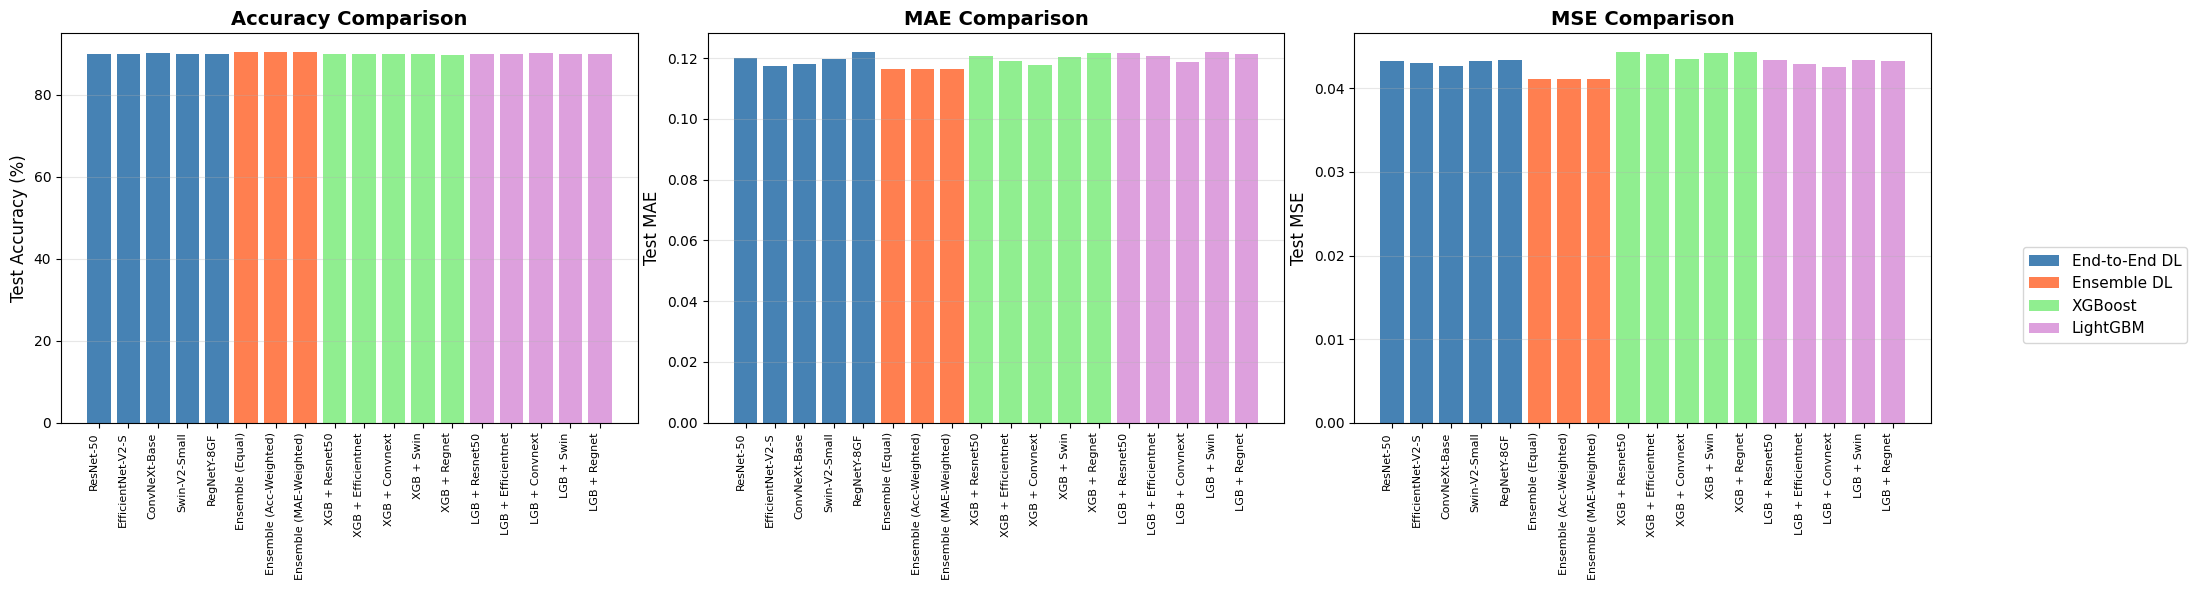

✓ Visualization saved to results/model_comparison/dl_vs_gb_comparison.png

SUMMARY BY METHOD
              Test Accuracy (%)                                  Test MAE  \
                           mean       std        max        min      mean   
Method                                                                      
End-to-End DL         89.979520  0.107152  90.118330  89.862328  0.119469   
Ensemble DL           90.487162  0.000821  90.488110  90.486688  0.116506   
LightGBM              89.993316  0.100294  90.119041  89.899306  0.120860   
XGBoost               89.918791  0.082863  90.035129  89.838861  0.119912   

                                             Test MSE                      \
                    std       min       max      mean       std       min   
Method                                                                      
End-to-End DL  0.001813  0.117441  0.122096  0.043121  0.000306  0.042642   
Ensemble DL    0.000012  0.116491  0.116513  0.041082  0.00

In [51]:
# ============================================================
# COMPREHENSIVE COMPARISON: DL vs GB
# ============================================================

comparison_data = []

# Add DL models (end-to-end)
for m in all_models_metrics:
    comparison_data.append({
        'Model': m['model_name'],
        'Method': 'End-to-End DL',
        'Test Accuracy (%)': m['test_accuracy'],
        'Test MAE': m['test_mae'],
        'Test MSE': m['test_mse']
    })

# Add Ensemble models (if they exist)
try:
    comparison_data.append({
        'Model': 'Ensemble (Equal)',
        'Method': 'Ensemble DL',
        'Test Accuracy (%)': ensemble_equal_accuracy,
        'Test MAE': ensemble_equal_mae,
        'Test MSE': ensemble_equal_mse
    })
    
    comparison_data.append({
        'Model': 'Ensemble (Acc-Weighted)',
        'Method': 'Ensemble DL',
        'Test Accuracy (%)': ensemble_weighted_accuracy,
        'Test MAE': ensemble_weighted_mae,
        'Test MSE': ensemble_weighted_mse
    })
    
    comparison_data.append({
        'Model': 'Ensemble (MAE-Weighted)',
        'Method': 'Ensemble DL',
        'Test Accuracy (%)': ensemble_mae_weighted_accuracy,
        'Test MAE': ensemble_mae_weighted_mae,
        'Test MSE': ensemble_mae_weighted_mse
    })
except NameError:
    print("⚠ Ensemble models not found - skipping ensemble comparison")

# Add XGBoost models
for name, m in xgboost_all_results.items():
    comparison_data.append({
        'Model': f"XGB + {name.capitalize()}",
        'Method': 'XGBoost',
        'Test Accuracy (%)': m['test_accuracy'],
        'Test MAE': m['test_mae'],
        'Test MSE': m['test_mse']
    })

# Add LightGBM models
for name, m in lightgbm_all_results.items():
    comparison_data.append({
        'Model': f"LGB + {name.capitalize()}",
        'Method': 'LightGBM',
        'Test Accuracy (%)': m['test_accuracy'],
        'Test MAE': m['test_mae'],
        'Test MSE': m['test_mse']
    })

ml_comparison_df = pd.DataFrame(comparison_data)

print("="*100)
print("COMPREHENSIVE COMPARISON: DEEP LEARNING VS GRADIENT BOOSTING")
print("="*100)
print(ml_comparison_df.to_string(index=False))
print("="*100)

ml_comparison_df.to_csv(comparison_dir / 'dl_vs_gb_comparison.csv', index=False)
print(f"\n✓ Saved to {comparison_dir / 'dl_vs_gb_comparison.csv'}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

methods = ml_comparison_df['Method'].unique()
colors = {'End-to-End DL': 'steelblue', 'Ensemble DL': 'coral', 'XGBoost': 'lightgreen', 'LightGBM': 'plum'}

# Accuracy comparison
for i, row in ml_comparison_df.iterrows():
    axes[0].bar(i, row['Test Accuracy (%)'], color=colors.get(row['Method'], 'gray'))
axes[0].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(ml_comparison_df)))
axes[0].set_xticklabels(ml_comparison_df['Model'], rotation=90, ha='right', fontsize=8)
axes[0].grid(True, alpha=0.3, axis='y')

# MAE comparison
for i, row in ml_comparison_df.iterrows():
    axes[1].bar(i, row['Test MAE'], color=colors.get(row['Method'], 'gray'))
axes[1].set_ylabel('Test MAE', fontsize=12)
axes[1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(ml_comparison_df)))
axes[1].set_xticklabels(ml_comparison_df['Model'], rotation=90, ha='right', fontsize=8)
axes[1].grid(True, alpha=0.3, axis='y')

# MSE comparison
for i, row in ml_comparison_df.iterrows():
    axes[2].bar(i, row['Test MSE'], color=colors.get(row['Method'], 'gray'))
axes[2].set_ylabel('Test MSE', fontsize=12)
axes[2].set_title('MSE Comparison', fontsize=14, fontweight='bold')
axes[2].set_xticks(range(len(ml_comparison_df)))
axes[2].set_xticklabels(ml_comparison_df['Model'], rotation=90, ha='right', fontsize=8)
axes[2].grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=method) for method, color in colors.items() if method in methods]
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.0, 0.5), fontsize=11, frameon=True)

plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.savefig(comparison_dir / 'dl_vs_gb_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Visualization saved to {comparison_dir / 'dl_vs_gb_comparison.png'}")

# Summary by method
print("\n" + "="*100)
print("SUMMARY BY METHOD")
print("="*100)
summary = ml_comparison_df.groupby('Method').agg({
    'Test Accuracy (%)': ['mean', 'std', 'max', 'min'],
    'Test MAE': ['mean', 'std', 'min', 'max'],
    'Test MSE': ['mean', 'std', 'min', 'max']
})
print(summary)

# Best overall
print("\n" + "="*100)
print("BEST MODELS")
print("="*100)
best_acc_idx = ml_comparison_df['Test Accuracy (%)'].idxmax()
best_mae_idx = ml_comparison_df['Test MAE'].idxmin()

print(f"\n🏆 Best Accuracy:")
print(f"   {ml_comparison_df.loc[best_acc_idx, 'Model']} ({ml_comparison_df.loc[best_acc_idx, 'Method']})")
print(f"   Accuracy: {ml_comparison_df.loc[best_acc_idx, 'Test Accuracy (%)']:.2f}%")

print(f"\n🏆 Best MAE:")
print(f"   {ml_comparison_df.loc[best_mae_idx, 'Model']} ({ml_comparison_df.loc[best_mae_idx, 'Method']})")
print(f"   MAE: {ml_comparison_df.loc[best_mae_idx, 'Test MAE']:.6f}")

print("\n" + "="*100)